# Part 2. Digit Recognition

### Using Traditional ML Classifiers (i.e. No Deep Learning)

In [1]:
import math 
import numpy as np
import cv2 as cv
import time
from scipy import stats 
from matplotlib import pyplot as plt
import skfuzzy as fuzz
import csv
import os
import pandas as pd
from sklearn.manifold import TSNE
import plotly.express as px
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, recall_score, precision_score, f1_score

import warnings
warnings.filterwarnings('ignore')

<hr />

## Dataset Creation

In this section, starting off from a set of 10 images (one for each digit) containing 50 samples each, we extract the contours of each digit and compute their Euler's number and Hu moments to create a dataset using those properties as the describing features of each digit sample, as they are invariant to transformations.

In [2]:
class Region:
    def __init__(self):
        self.xm = 0
        self.ym = 0
        self.xx = 0
        self.yy = 0
        self.xy = 0
        self.xxx = 0
        self.yyy = 0
        self.xxy = 0
        self.xyy = 0
        self.Perimetro = 0
        self.Area = 0
        self.closed = False
        self.edgePoints = []
        self.red = 0
        self.green = 0
        self.blue = 0
    def addPoint(self,x,y,isedge,color):
        self.xm = self.xm + x
        self.ym = self.ym + y
        self.xx = self.xx + x*x
        self.yy = self.yy + y*y
        self.xy = self.xy + x*y
        self.xxx = self.xxx + x*x*x
        self.yyy = self.yyy + y*y*y
        self.xxy = self.xxy + x*x*y
        self.xyy = self.xyy + x*y*y
        self.Area = self.Area + 1
        self.red = self.red + color[0]
        self.green = self.green + color[1]
        self.blue = self.blue + color[2]

        if isedge > 0:
            self.Perimetro = self.Perimetro + 1
            if (isedge & 1) > 0: #up
                self.edgePoints.append((x+0.5,y+0.001))
            if (isedge & 2) > 0: #left
                self.edgePoints.append((x+0.001,y+0.5))
            if (isedge & 4) > 0: #down
                self.edgePoints.append((x+0.5,y+0.999))
            if (isedge & 8) > 0: #right
                self.edgePoints.append((x+0.999,y+0.5))
    def addRegion(self,region):
        if (self.closed == False) and (region.closed == False) and (region.Area > 0):
            self.xm = self.xm + region.xm
            self.ym = self.ym + region.ym
            self.xx = self.xx + region.xx
            self.yy = self.yy + region.yy
            self.xy = self.xy + region.xy
            self.xxx = self.xxx + region.xxx
            self.yyy = self.yyy + region.yyy
            self.xxy = self.xxy + region.xxy
            self.xyy = self.xyy + region.xyy
            self.Area = self.Area + region.Area
            self.Perimetro = self.Perimetro + region.Perimetro
            self.red = self.red + region.red
            self.green = self.green + region.green
            self.blue = self.blue + region.blue
            for n in range(len(region.edgePoints)):
                self.edgePoints.append(region.edgePoints[n])
    def closeRegion(self):
        if (self.Area > 0) and (self.closed == False):
            self.xm = self.xm/self.Area
            self.ym = self.ym/self.Area
            self.xx = self.xx/self.Area - self.xm*self.xm
            self.yy = self.yy/self.Area - self.ym*self.ym
            self.xy = self.xy/self.Area - self.xm*self.ym
            self.red = self.red/self.Area
            self.green = self.green/self.Area
            self.blue = self.blue/self.Area
            self.closed = True
        

Function to transform the points that conform a digit and make their connection smoother (useful for visualization purposes)

In [3]:
def smoothPointSet(points,steps):
    lpts = len(points)
    for stp in range(steps):
        apt = np.array(points)
        for n in range(lpts):
            bidx = (n + lpts - 1) % lpts
            uidx = (n + lpts + 1) % lpts
            points[n] = ((apt[bidx][0]+apt[n][0]+apt[uidx][0])/3,(apt[bidx][1]+apt[n][1]+apt[uidx][1])/3)
    return points

Function to get the properties of a digit (which comes as a set of points of the same connected component)

In [4]:
def getInvariantFeatures(points, displayIndividual = True):
    outlinePoints = points

    # Convert the list of points to integer coordinates
    points = np.array([(int(pt[0]), int(pt[1])) for pt in outlinePoints[0]])

    xMin, yMin = np.min(points, axis=0)
    xMax, yMax = np.max(points, axis=0)
    
    # Create a binary image that fits the bounding box (a brack BG image)
    binary_image = np.zeros((yMax - yMin + 1, xMax - xMin + 1), dtype=np.uint8)
    shifted_points = points - [xMin, yMin]
    
    # Draw the digit in the binary image (white FG)
    for x, y in shifted_points:
        binary_image[y, x] = 1
    
    # Compute Hu Moments
    moments = cv.moments(binary_image)
    hu_moments = cv.HuMoments(moments).flatten()
    hu1, hu2, hu3, hu4, hu5, hu6, hu7 = hu_moments
    
    # Compute Euler's number
    num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(binary_image, connectivity = 8)
    euler_number = num_labels - 1 

    # Euler's (Professor's version)
    euler_number = 2 - len(points)
    
    if displayIndividual:
        print("Hu Moments:", hu_moments)
        print("Euler's Number:", euler_number)
        
        # Display the generated binary image
        plt.imshow(binary_image, cmap='gray')
        plt.title("Digit Sample from the Training Set")
        plt.show()

    return euler_number, hu1, hu2, hu3, hu4, hu5, hu6, hu7, xMin, yMin, xMax, yMax

Function to order the different points that make up a component (in this case, the dots that when together, make up a digit)

In [5]:
def orderPointSet(opoints,EdgeImage):
    orderpointsList = []
    if len(opoints) > 0:
        points = opoints.copy()
        neigbors = np.array([(1,0),(1,1),(0,1),(-1,1),(-1,0),(-1,-1),(0,-1),(1,-1),(0,0)])*0.5
        plen = len(points)
        n = 0
        last = 0
        inserted = 0
        orderpoints = []
        orderpoints.append(points[0])
        points.pop(0)
        lastidx = 0
        who = 0
        for inserted in range(plen-1):
            n = 0
            cpt = np.array(orderpoints[last])
            edgetype = EdgeImage[int(cpt[1]),int(cpt[0])]
            dis = 1
            thepoints = np.array(points)                
            thesum = np.sum(abs(thepoints-cpt),axis=1)
            lastdir = np.sum(np.square(neigbors-neigbors[lastidx]),axis=1)
            dis = 10
            idx = lastidx;
            for n in range(len(points)):
                if thesum[n] <= 2:
                    npoints = cpt + neigbors
                    theNsum = np.sum(np.abs(npoints-thepoints[n]),axis=1) + 0.01*lastdir
                    for nn in range(8):
                        nedgetype = EdgeImage[int(npoints[nn,1]),int(npoints[nn,0])]
                        dist = theNsum[nn] + 0.001*((edgetype ^ nedgetype) > 0)
                        if dist < dis:
                            dis = dist
                            idx = nn
                            who = n
            if dis < 1.0:
                lastidx = idx
                orderpoints.append(points[who])
                points.pop(who)
            else:
                if len(orderpoints) > 2:
                    orderpointsList.append(orderpoints)
                orderpoints = []
                orderpoints.append(points[0])
                points.pop(0)
                last = 0
            last = len(orderpoints) - 1
        if len(orderpoints) > 2:
            orderpointsList.append(orderpoints)
    return orderpointsList    

Function to get the segments of the image

In [6]:

def SegmentationRegions(image,colorimg): 
    regions = []
    si,sj = image.shape;
    fimage = image.astype(np.int16)
    EdgeImage = image.astype(np.int16)
        
    regionlabels = image[:,:];
    regionlabels = regionlabels.astype(np.int32)
    shortlabellut = np.zeros((int(si*sj/100+1),), dtype=np.int32)
    labellut = shortlabellut
    upKernel = np.array((
    [0, -1, 0],
    [0, 1, 0],
    [0, 0, 0]), dtype=np.int16)
    upsameI = abs(cv.filter2D(fimage,-1,upKernel)) == 0  
    leftKernel = np.array((
    [0, 0, 0],
    [-1, 1, 0],
    [0, 0, 0]), dtype=np.int16)
    leftsameI = abs(cv.filter2D(fimage,-1,leftKernel)) == 0
    downKernel = np.array((
    [0, 0, 0],
    [0, 1, 0],
    [0, -1, 0]), dtype=np.int16)
    downsameI = abs(cv.filter2D(fimage,-1,downKernel)) == 0  
    rightKernel = np.array((
    [0, 0, 0],
    [0, 1, -1],
    [0, 0, 0]), dtype=np.int16)
    rightsameI = abs(cv.filter2D(fimage,-1,rightKernel)) == 0
    currentlabel=0
    uplabelArray = regionlabels[0,:]
    upsame = False
    leftsame = False
    thelabel = 0
    uplabel = 0
    leftlabel = 0
    regions.append(Region())
    for i in range(si):
        leftlabel = labellut[regionlabels[i,0]]
        for j in range(sj):
            color = colorimg[i,j,:]
            thelabel = leftlabel 
            upsame = False
            leftsame = False
            EdgeImage[i,j] = 1*(not upsameI[i,j]) +  2*(not leftsameI[i,j]) + 4*(not downsameI[i,j]) + 8*(not rightsameI[i,j])
            if i>0:
                uplabel = uplabelArray[j]
                upsame = upsameI[i,j]
                if upsame:
                    thelabel = uplabel
            if j>0:
                leftsame = leftsameI[i,j]
                if leftsame:
                    if thelabel > leftlabel:
                        thelabel = leftlabel                
                    if upsame:
                        thelabel = labellut[thelabel]
                        labellut[leftlabel] = thelabel
                        labellut[uplabel] = thelabel
            if (not(upsame) and  not(leftsame)):
                currentlabel = currentlabel + 1
                regions.append(Region())
                thelabel = currentlabel
                if (currentlabel >= labellut.size):
                    labellut = np.append(labellut, shortlabellut)
                labellut[currentlabel] = currentlabel
            else:
                thelabel = labellut[thelabel]
            regionlabels[i,j] = thelabel
            regions[thelabel].addPoint(j,i,EdgeImage[i,j],color)
            leftlabel = thelabel
        uplabelArray = regionlabels[i,:]
    print(len(regions))
    lreg = len(regions)
    changes = 1
    while changes > 0:
        changes = 0
        for idx in range(lreg):
            newlabel = labellut[idx]
            if regions[idx].Area > 0 and idx != newlabel:
                changes = changes + 1
                regions[newlabel].addRegion(regions[idx])
                regions[idx].__init__()
            labellut[idx] = labellut[newlabel]
        print(changes)
    closed = 0
    for n in range(lreg):
        if (n == labellut[n]) and (regions[n].Area > 0):
            closed = closed + 1
            regions[n].closeRegion()
    print(closed)
    regionlabels = labellut[regionlabels]
    return regionlabels, regions, EdgeImage


Definition of _sensitivity_ Perimeters. <br />
We set thresholds to limit the perimeters allowed. It is necessary because some digits have inner figures (like 8, which has 2 circles inside), so we want to filter only the most exterior contour of the digit. Also, considering that the segmentation can introduce noise and detect things in the paper that are not digits, it is necessary to set these thresholds.

In [7]:
PERIMETERS = [
    (300, 2000), # 0
    (100, 700),
    (150, 700), # 2
    (250, 500),
    (200, 700), # 4
    (200, 1000),
    (200, 700), # 6
    (150, 700),
    (400, 700), # 8
    (200, 700)
]


For each source image in the format _digit/X.jpeg_, extract the properties of each digit handwritten. There are 50 samples on each image, however, because of the thresholds set previously, in some cases, some samples won't be added, however, they are all around 50 samples approx.

#########################################################################

EXTRACTION OF DIGIT 0

#########################################################################


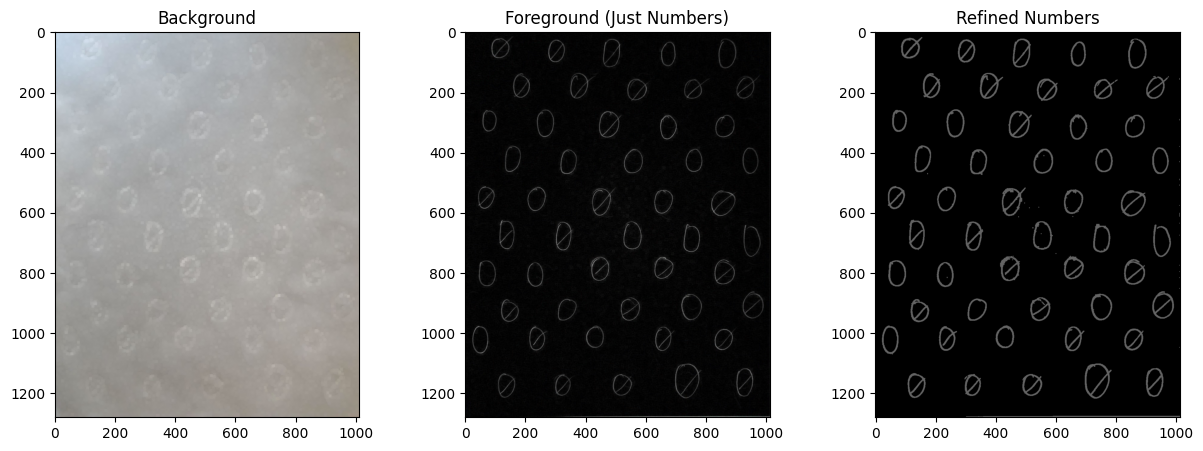

6061
5868
53
0
192


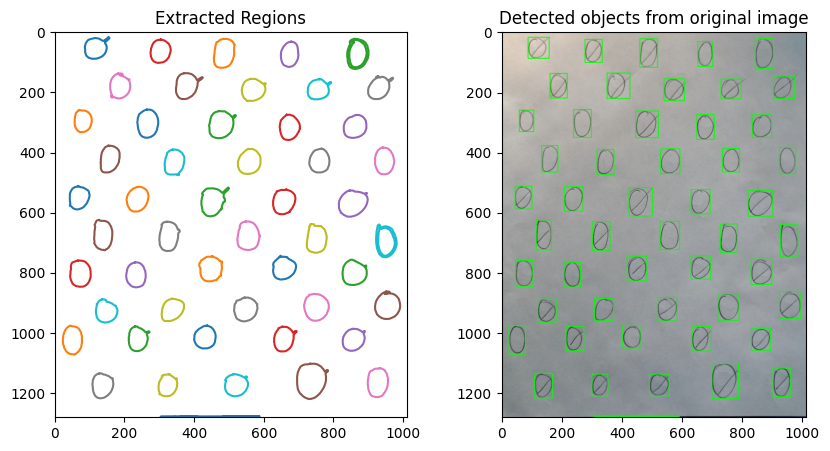

#########################################################################

EXTRACTION OF DIGIT 1

#########################################################################


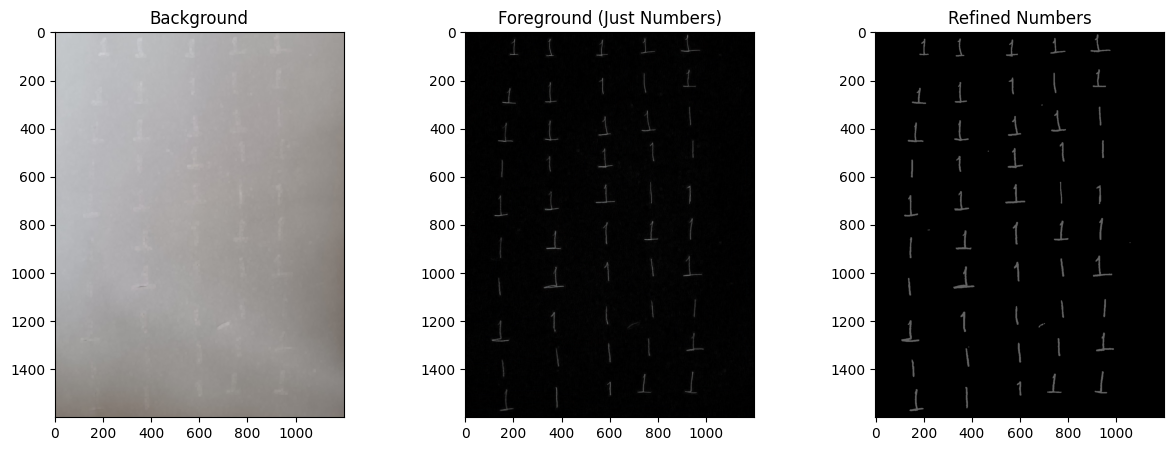

1008
944
39
0
63


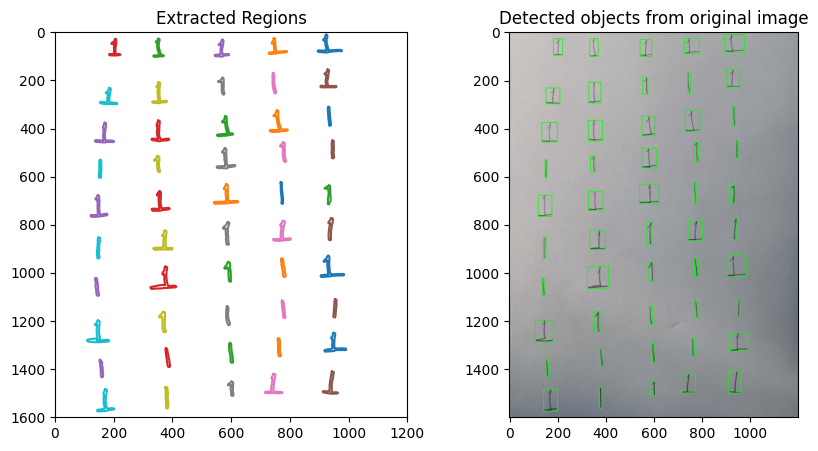

#########################################################################

EXTRACTION OF DIGIT 2

#########################################################################


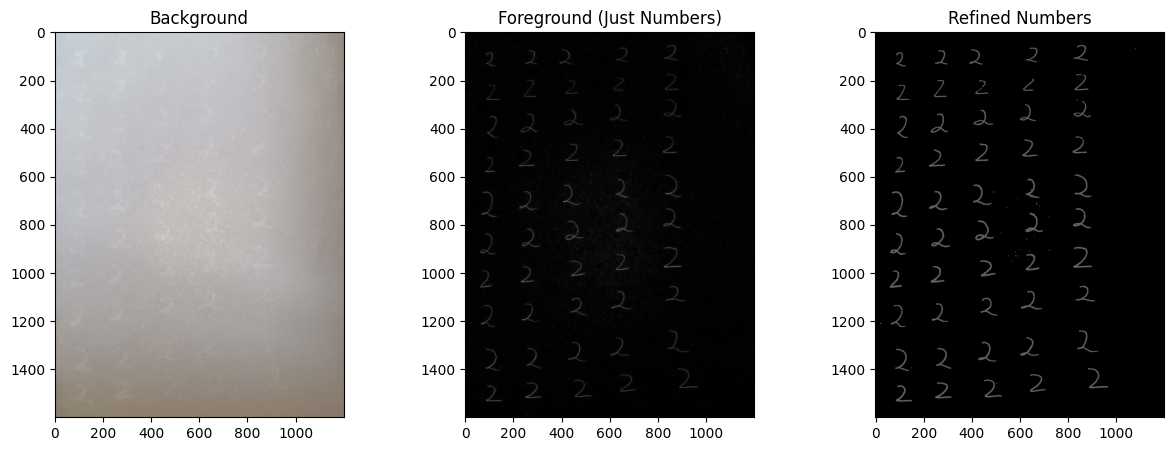

3120
3021
59
0
98


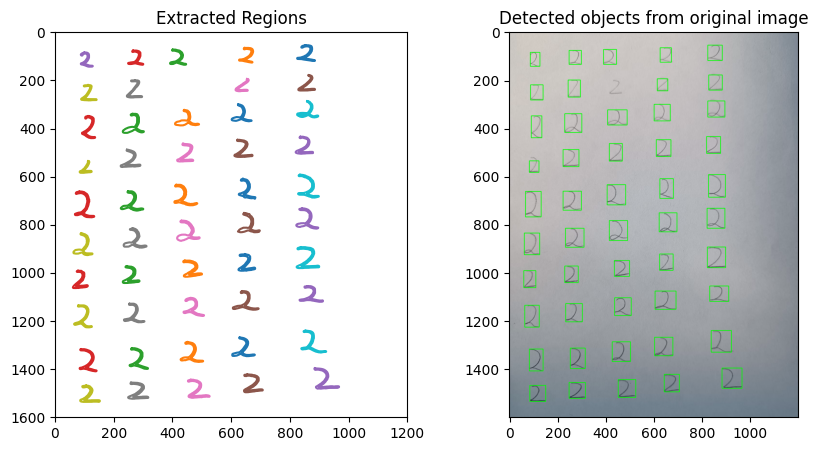

#########################################################################

EXTRACTION OF DIGIT 3

#########################################################################


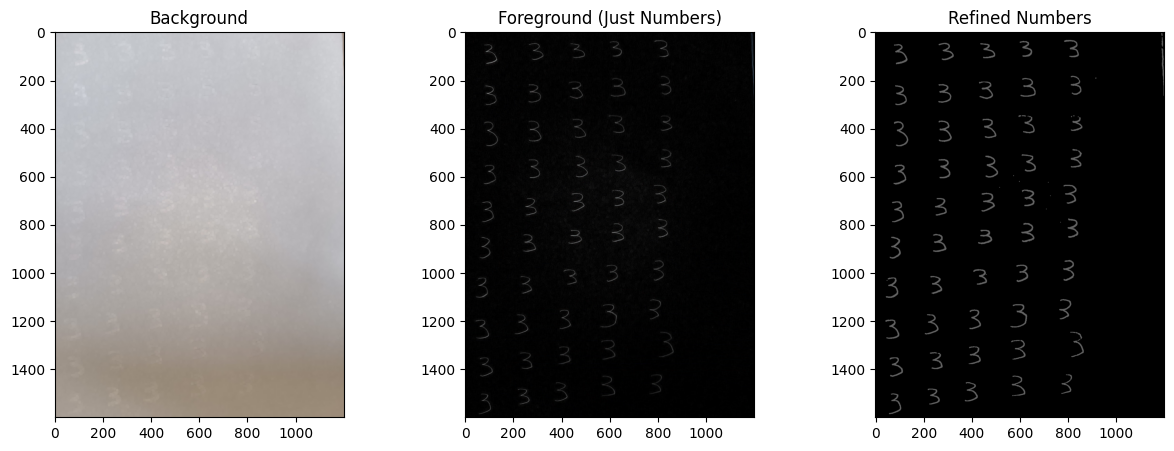

2905
2823
62
0
81


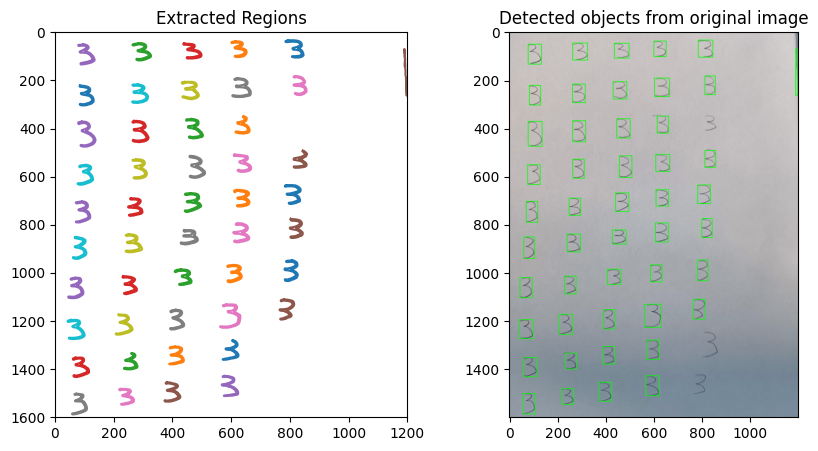

#########################################################################

EXTRACTION OF DIGIT 4

#########################################################################


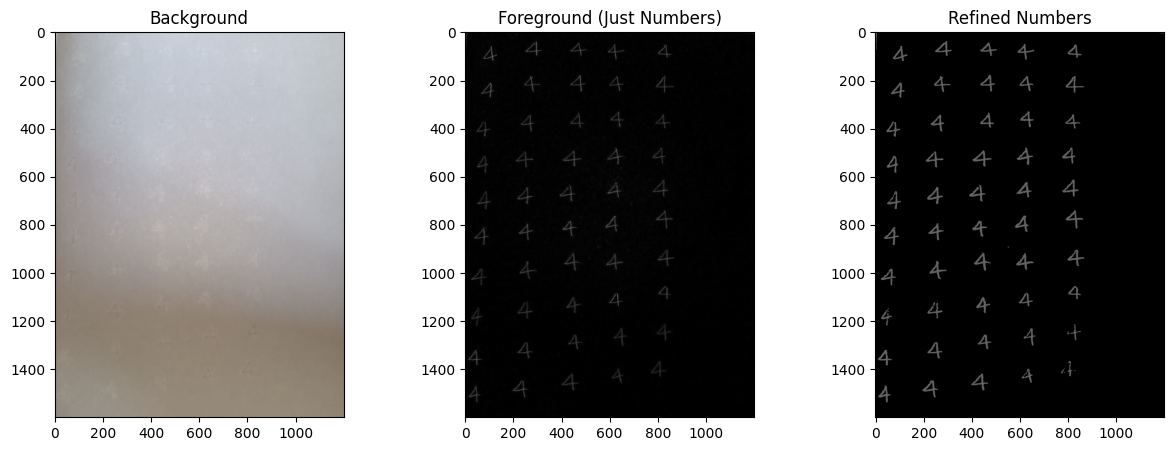

2917
2788
74
0
128


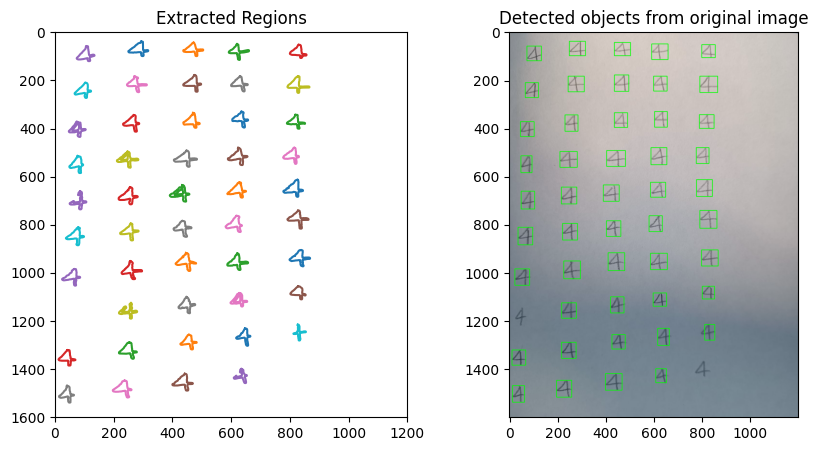

#########################################################################

EXTRACTION OF DIGIT 5

#########################################################################


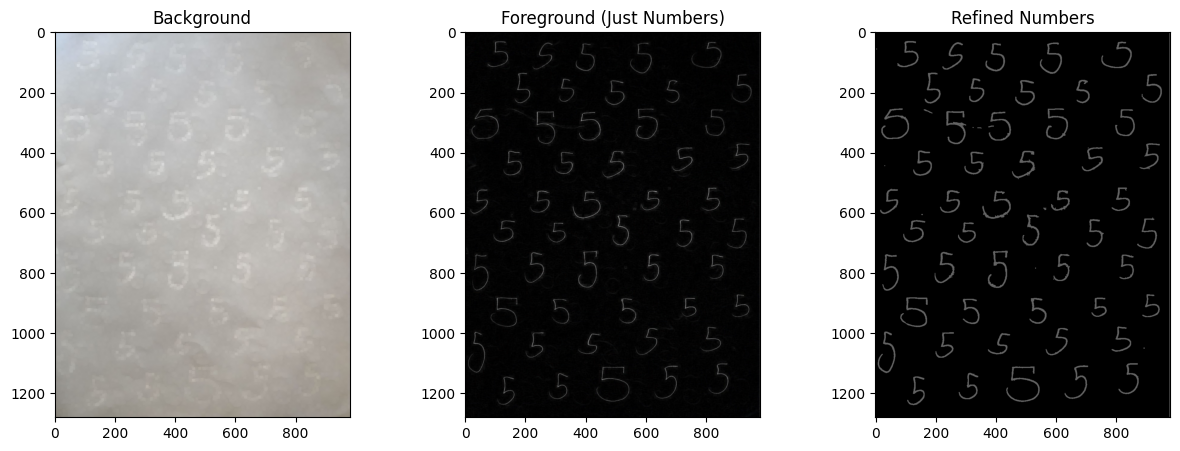

3237
3162
156
0
74


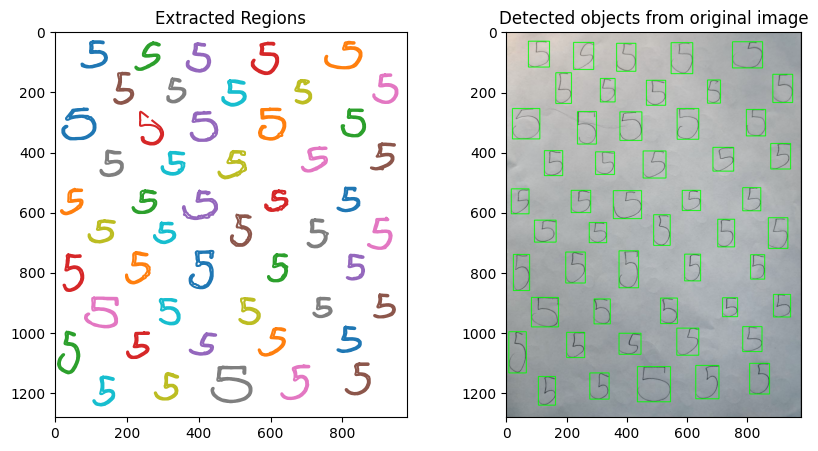

#########################################################################

EXTRACTION OF DIGIT 6

#########################################################################


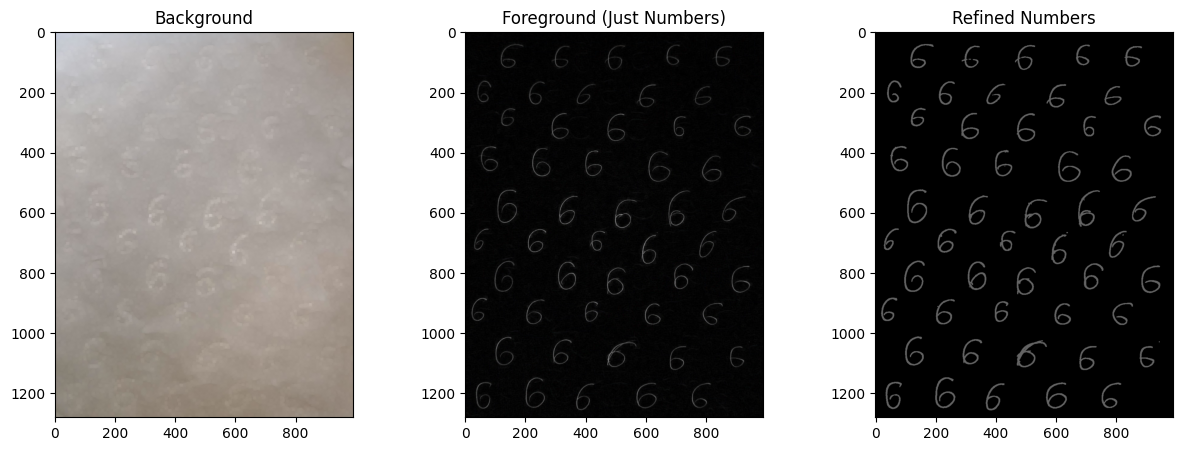

4957
4859
115
0
97


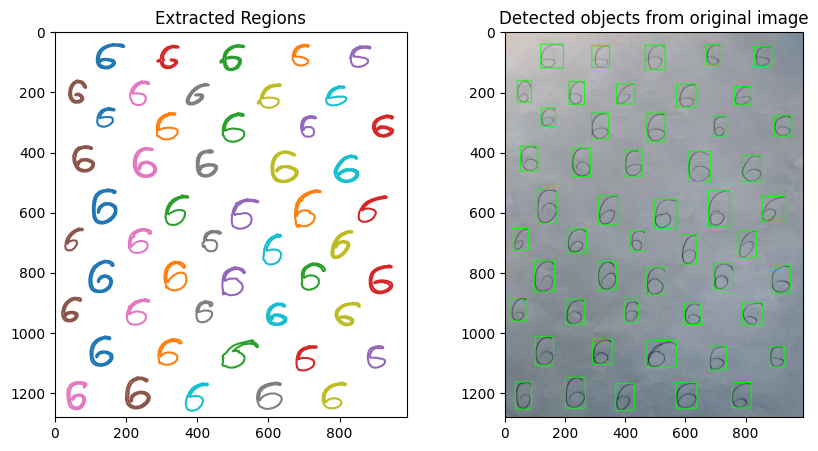

#########################################################################

EXTRACTION OF DIGIT 7

#########################################################################


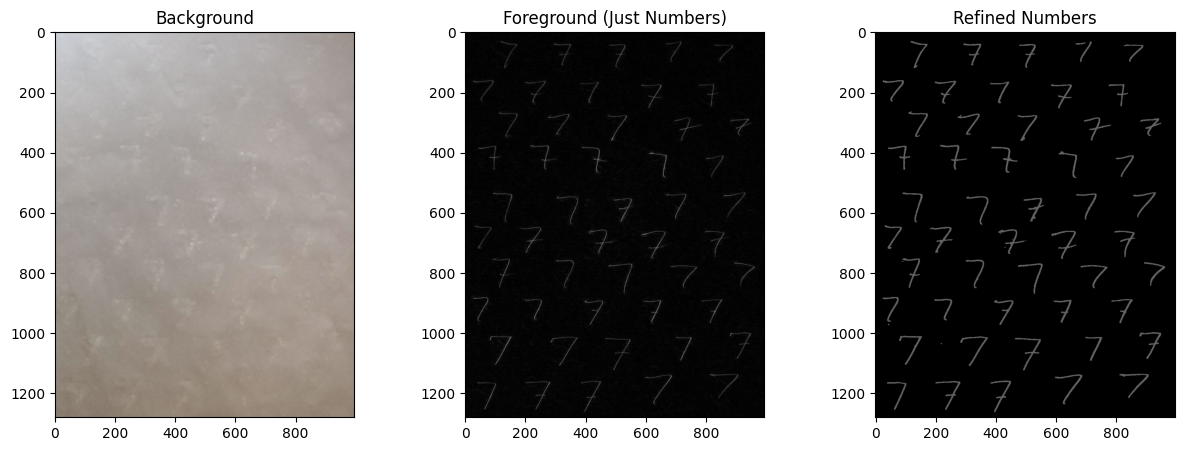

4127
4064
82
0
62


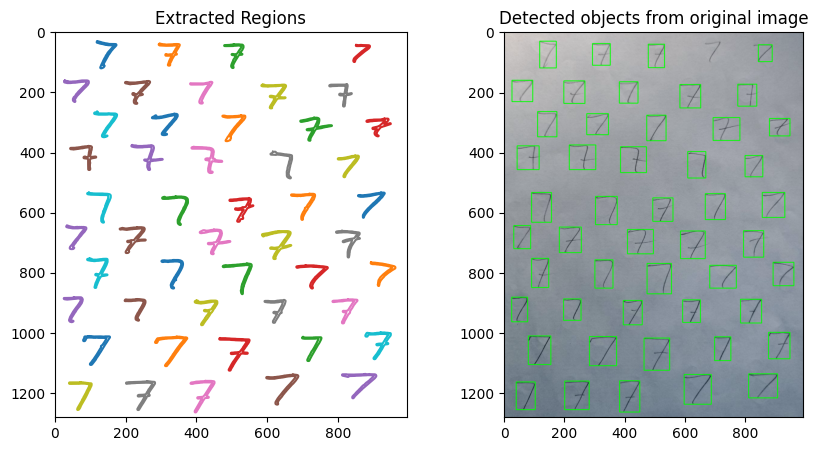

#########################################################################

EXTRACTION OF DIGIT 8

#########################################################################


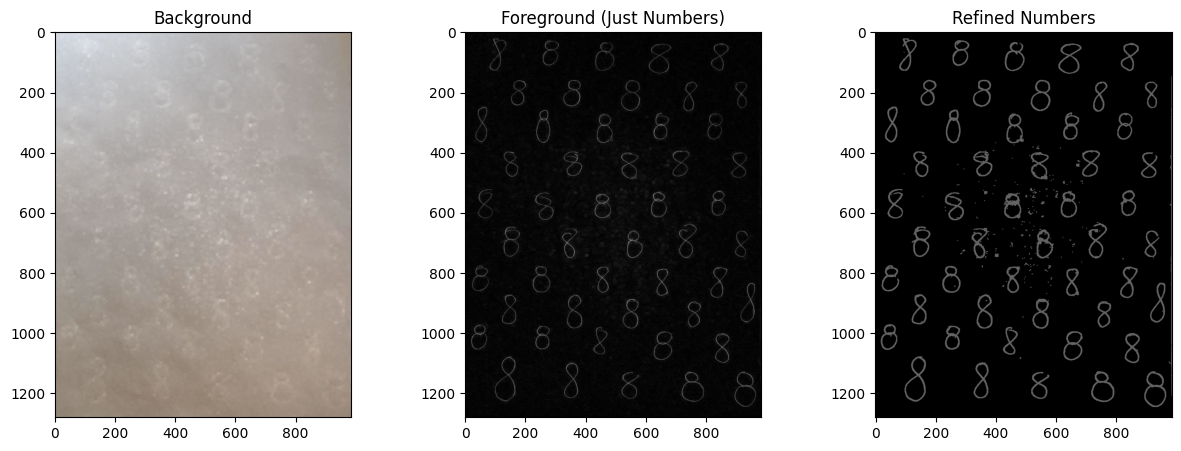

5635
5293
81
0
341


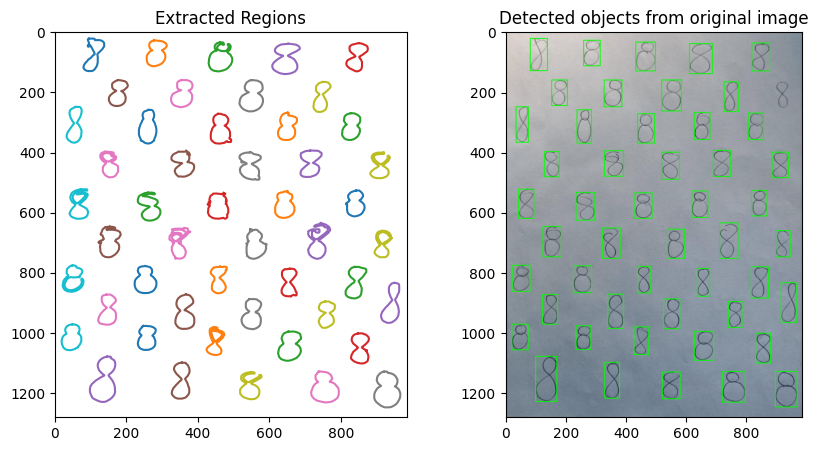

#########################################################################

EXTRACTION OF DIGIT 9

#########################################################################


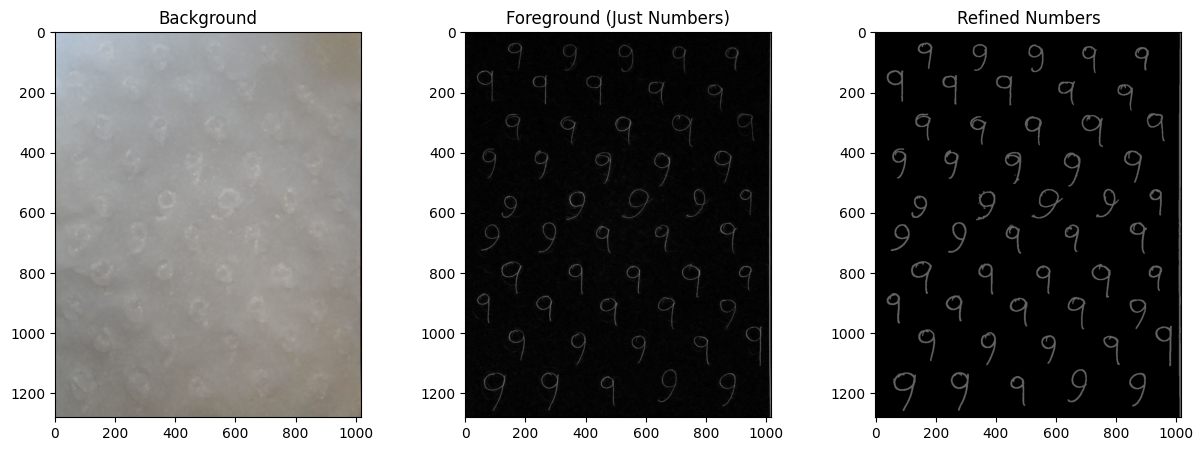

3983
3829
116
0
153


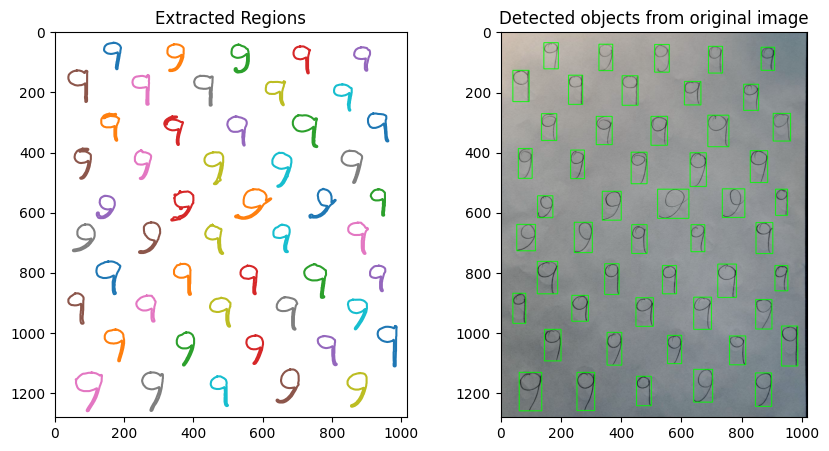

In [8]:

featuresfile = open(f"trainingDataset_AllDigits.csv", "w",newline="")
writer = csv.writer(featuresfile)
colnames=["Digit", "euler", "Hu1", "Hu2", "Hu3", "Hu4", "Hu5", "Hu6", "Hu7"]
writer.writerow(colnames)

for digit in range(0, 10):

    print("#########################################################################")
    print()
    print(f"EXTRACTION OF DIGIT {digit}")
    print()
    print("#########################################################################")

    frame = cv.imread(os.path.join("digits", f"{digit}.jpeg"))
    rawImg = frame.copy()

    kernel = np.ones((5,5),np.uint8)
    bkgnd = cv.dilate(frame,kernel,iterations = 1)
    bkgnd = cv.dilate(bkgnd,kernel,iterations = 1)

    frame = (bkgnd - frame)
    frgnd = frame.copy()
    
    kernel = np.ones((3,3),np.uint8)
    frame = cv.dilate(frame,kernel,iterations = 1)
    
    green = frame[:,:,2]
    ret,img = cv.threshold(green, 32, 100, 0)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(cv.cvtColor(bkgnd, cv.COLOR_BGR2RGB))
    ax[0].set_title("Background")
    
    ax[1].imshow(cv.cvtColor(frgnd, cv.COLOR_BGR2RGB))
    ax[1].set_title("Foreground (Just Numbers)")
    
    ax[2].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    ax[2].set_title("Refined Numbers")
    plt.show()
    
    # ###################
    labeled, regions, EdgeImage = SegmentationRegions(img,frame)

    labeled = labeled % 21

    img = cv.normalize(labeled, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
    im_color = cv.applyColorMap(img, cv.COLORMAP_HSV)
    im_color = cv.medianBlur(im_color,3)
    RGB_im = cv.cvtColor(im_color, cv.COLOR_BGR2RGB)

    # ###################

    fig, ax = plt.subplots(1,2, figsize=(10, 5))
    boundaries = []
    for n in range(len(regions)-2):
        idx = n+2
        if regions[idx].Perimetro > PERIMETERS[digit][0]:
            if regions[idx].Perimetro < PERIMETERS[digit][1]:

                pointlist = orderPointSet(regions[idx].edgePoints, EdgeImage)
                smoothpoints = np.array(smoothPointSet(pointlist[0],3))
                euler, hu1, hu2, hu3, hu4, hu5, hu6, hu7, xMin, yMin, xMax, yMax = getInvariantFeatures(pointlist, displayIndividual=False)
                rowfeature = [int(digit), euler, hu1, hu2, hu3, hu4, hu5, hu6, hu7]
                writer.writerow(rowfeature)

                boundaries.append(((xMin, yMin), (xMax, yMax)))

                ax[0].plot(smoothpoints[:,0],smoothpoints[:,1])

    ax[0].set_ylim(frame.shape[0], 0)
    ax[0].set_xlim(0, frame.shape[1])
    ax[0].set_title("Extracted Regions")

    boundedImg = rawImg.copy()
    for startPoint, endPoint in boundaries:
        cv.rectangle(boundedImg, startPoint, endPoint, (0,255,0), 2)
    ax[1].imshow(boundedImg)
    ax[1].set_title("Detected objects from original image")

    plt.show()

featuresfile.close()

<hr />

## Model Training

In this section, based on the created CSV file with approximately 50 samples per digit, we train 3 different classifiers: 

* Support Vector Classifier (SVC)
* Decision Trees (DT)
* Random Forest (RF)

We use out Student ID as test sets to assess the quality of recognition using this simpler approach.

In [9]:
df = pd.read_csv("trainingDataset_AllDigits.csv")
df

Digit  euler       Hu1        Hu2        Hu3       Hu4        Hu5  \
0        0   -314  5.384709   1.489993   5.909982  0.759683  -0.554882   
1        0   -310  6.474037   5.442867   0.530058  0.013285   0.000879   
2        0   -630  3.107118   1.435844   0.450297  0.047508   0.002103   
3        0   -270  5.802750   1.481768   0.525297  0.012451  -0.000710   
4        0   -270  5.633965   3.978982   0.280501  0.020723   0.001183   
..     ...    ...       ...        ...        ...       ...        ...   
489      9   -446  5.136887  10.746555  10.808438  2.923951   8.201701   
490      9   -496  5.249713   6.847667  28.600078  1.383320   1.851842   
491      9   -456  5.162316  11.233403  26.504664  2.082517 -15.215564   
492      9   -420  4.708165   8.068559  10.216617  1.514683  -1.135186   
493      9   -316  4.098544   8.365897  11.077894  0.556120  -0.610414   

          Hu6        Hu7  
0    0.881351  -1.511026  
1    0.030994   0.000685  
2    0.056756   0.006623  
3    0.002768   0.000714  
4    0.041180   0.001047  
..        ...        ...  
489 -3.800582  14.245162  
490 -3.518296   8.501622  
491 -4.441049  -2.804761  
492 -4.166123   5.849352  
493 -1.608316   1.238018  

[494 rows x 9 columns]

Simple dimensionality reduction visualization to get a glimpse into the separation of classes (digits), as there are some that could be easily confused (like 1 and 7).

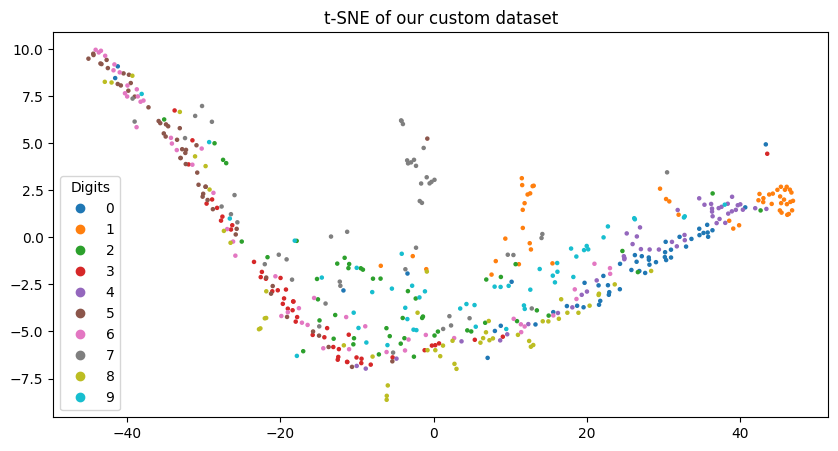

In [10]:
tsne = TSNE(n_components=2, random_state=42)
projections = tsne.fit_transform(df.drop(columns=["Digit"]))

plt.figure(figsize=(10, 5))
scatter = plt.scatter(projections[:, 0], projections[:, 1], c=df["Digit"].astype(int), cmap="tab10", s=5)
plt.legend(*scatter.legend_elements(), title="Digits")
plt.title("t-SNE of our custom dataset")
plt.show()

Display the class distribution, which, as expected, all classes are near 50 samples.

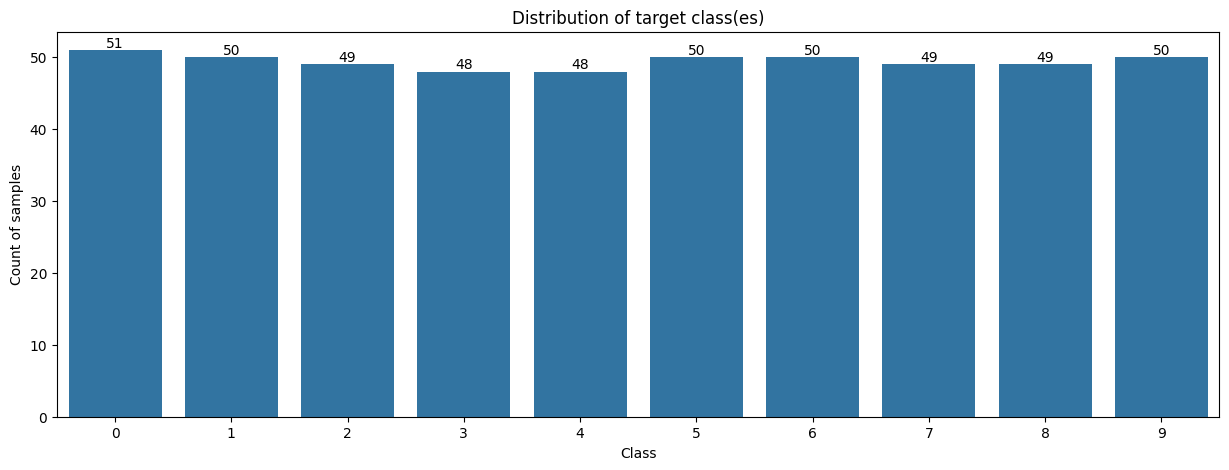

In [11]:
plt.figure(figsize=(15, 5))
graph = sns.countplot(x="Digit", data=df)
graph.bar_label(graph.containers[0])
plt.title("Distribution of target class(es)")
plt.xlabel("Class")
plt.ylabel("Count of samples")
plt.show()

In [12]:
df.nunique()

Digit     10
euler    191
Hu1      494
Hu2      494
Hu3      494
Hu4      494
Hu5      494
Hu6      494
Hu7      494
dtype: int64

Configuration of the folds (to perform K-Fold cross validation) and definition of variables to hold the results of the model training.

In [13]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

modelsResults = {
    "SVC" : {
        "Accuracy" : [],
        "AUC" : [],
        "Recall" : [],
        "Precision" : [],
        "F1Score" : []
    },
    "DT" : {
        "Accuracy" : [],
        "AUC" : [],
        "Recall" : [],
        "Precision" : [],
        "F1Score" : []
    },
    "RF" : {
        "Accuracy" : [],
        "AUC" : [],
        "Recall" : [],
        "Precision" : [],
        "F1Score" : []
    },
}

X = df.drop(columns=["Digit"])
y = df["Digit"]

**Hyperparameter Tuning**

This block is to test multiple different model configurations (i.e. hyperparameters) in an attempt to maximize the performance of the models before actually defining the final model that will be used.

_**SUPPORT VECTOR CLASSIFIER**_

K FOLD #0


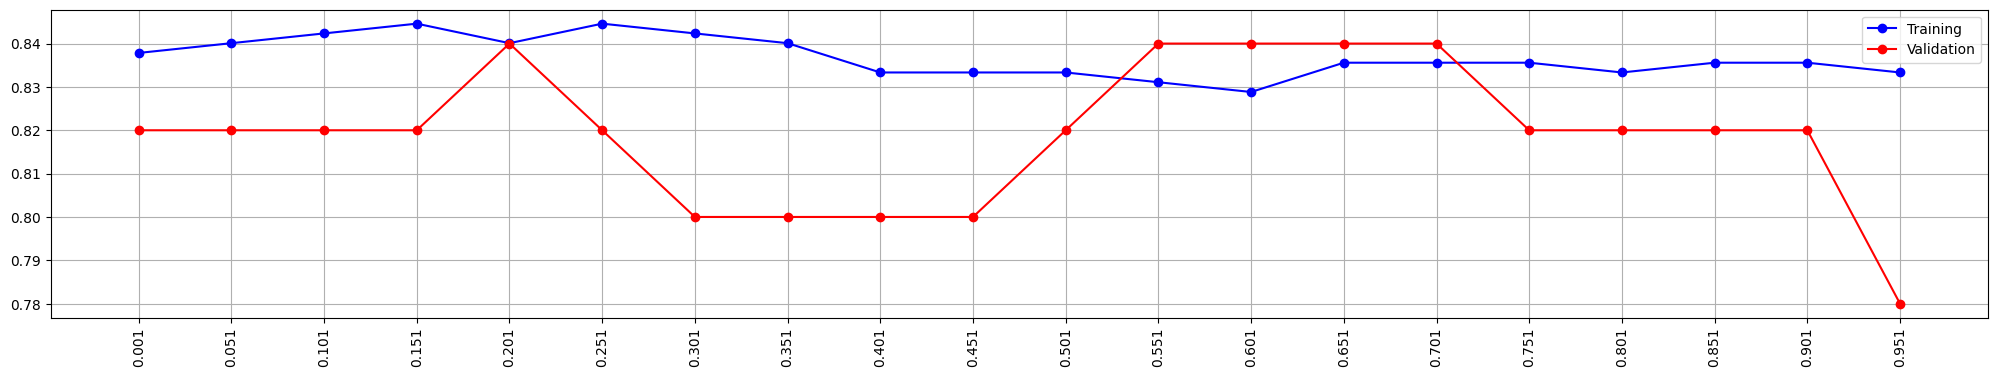

K FOLD #1


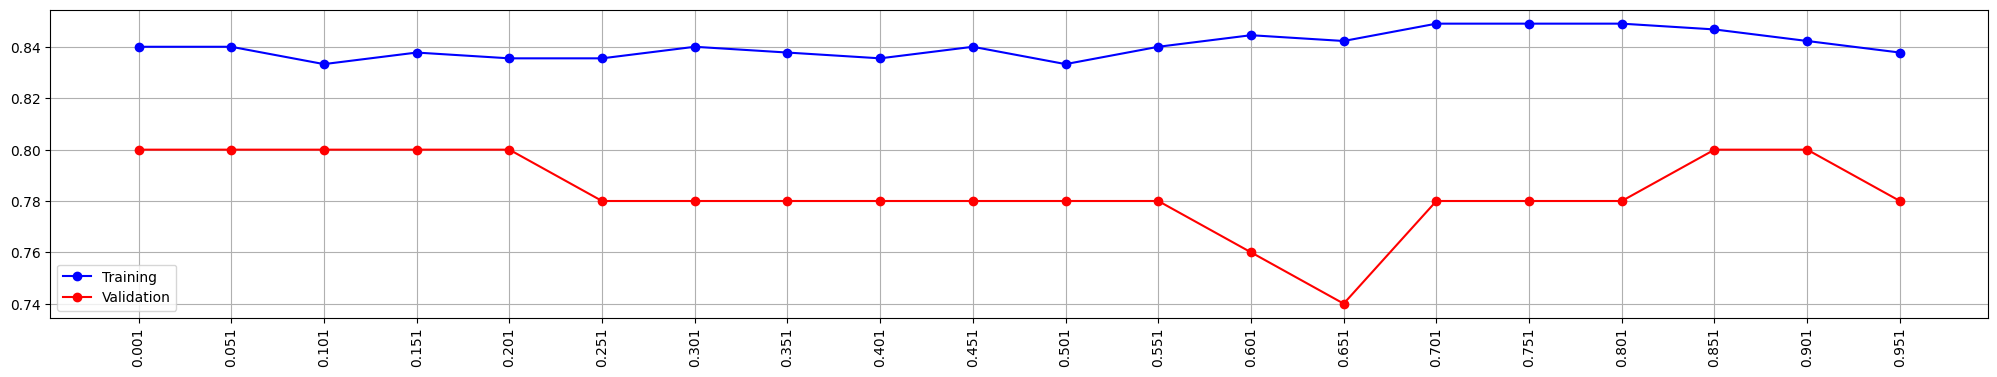

K FOLD #2


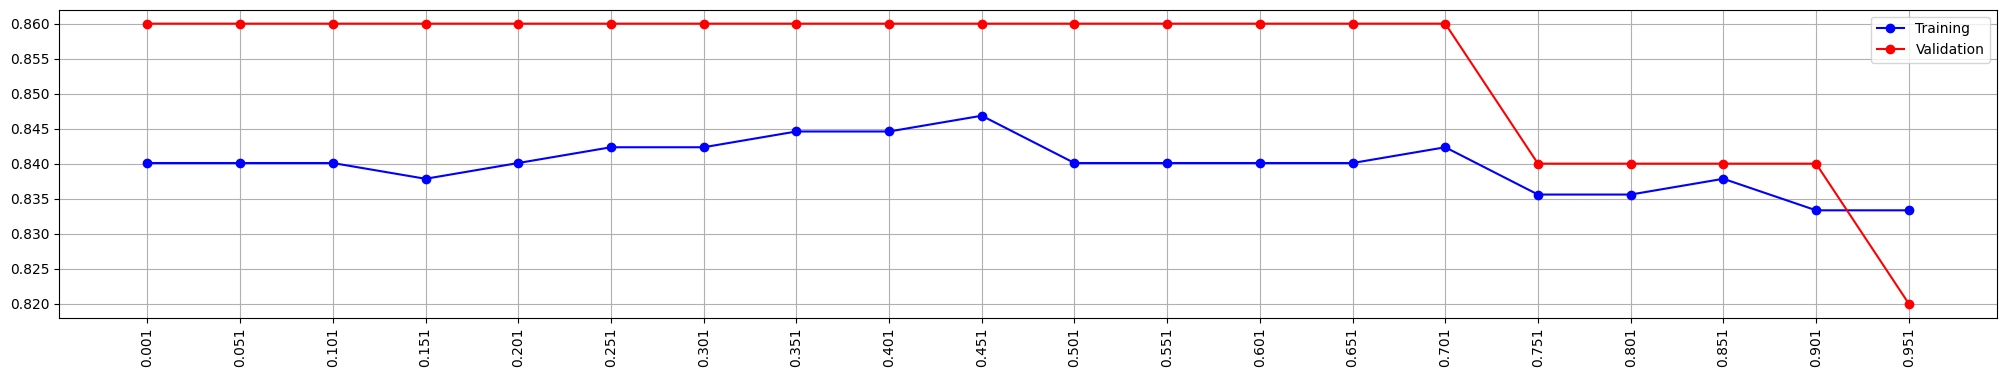

K FOLD #3


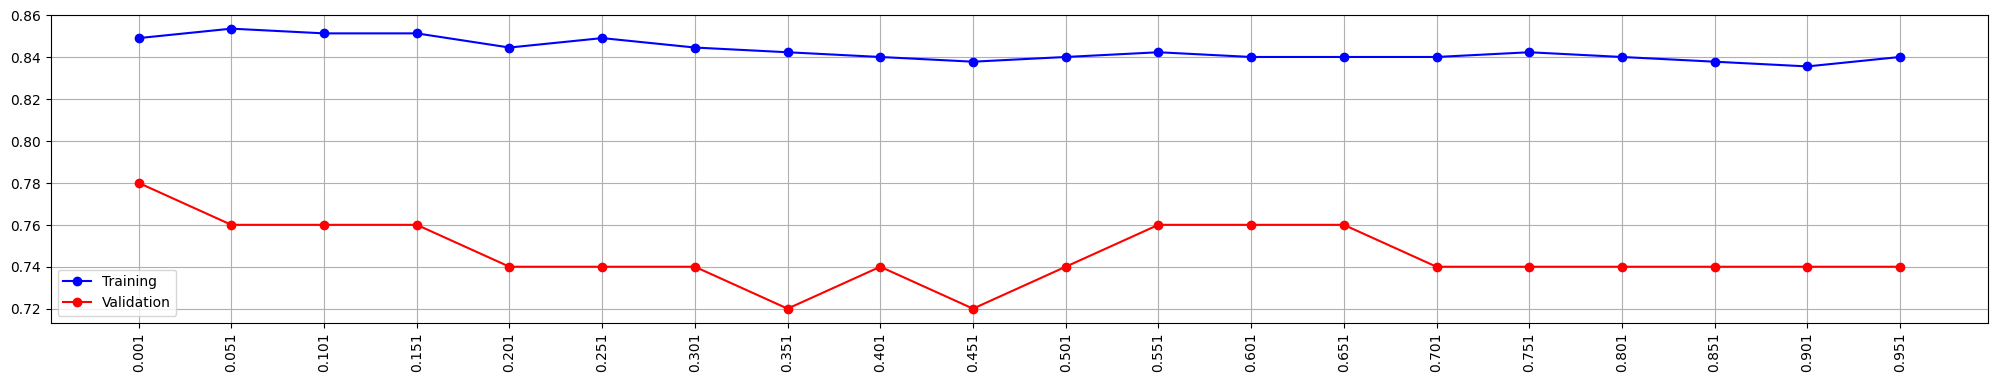

K FOLD #4


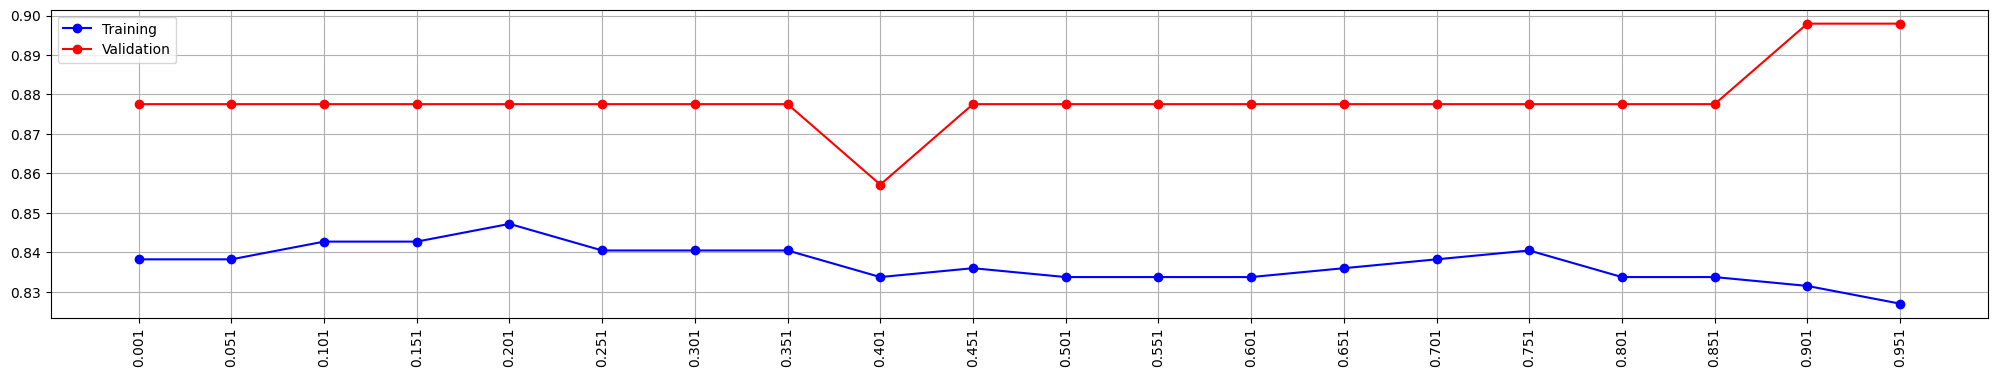

K FOLD #5


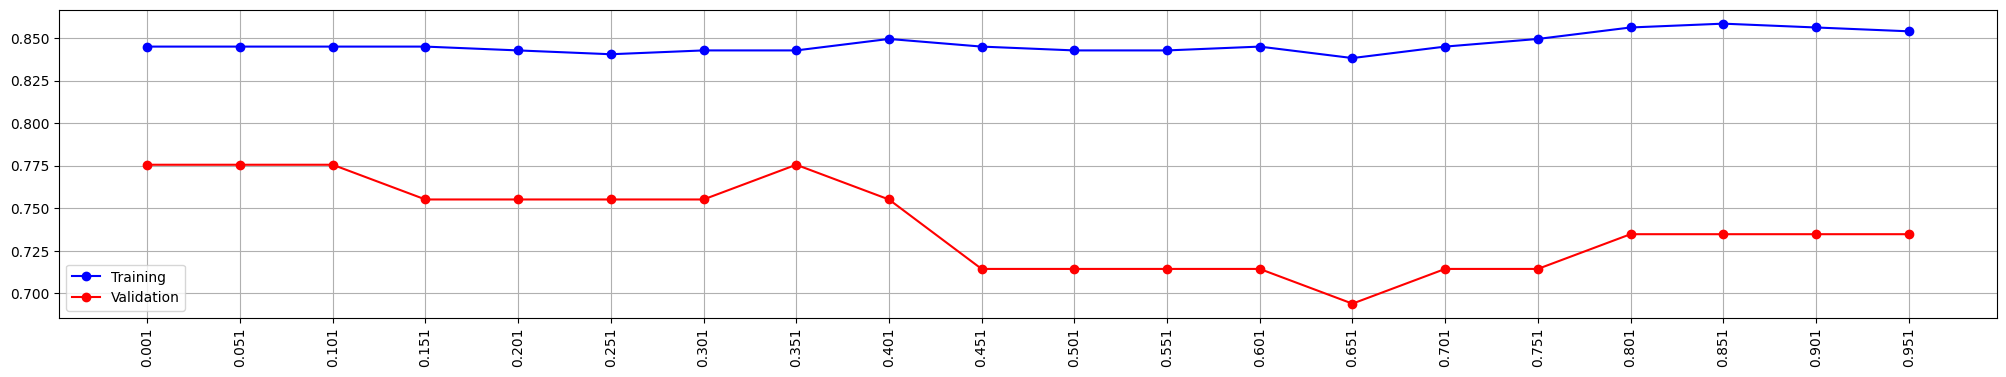

K FOLD #6


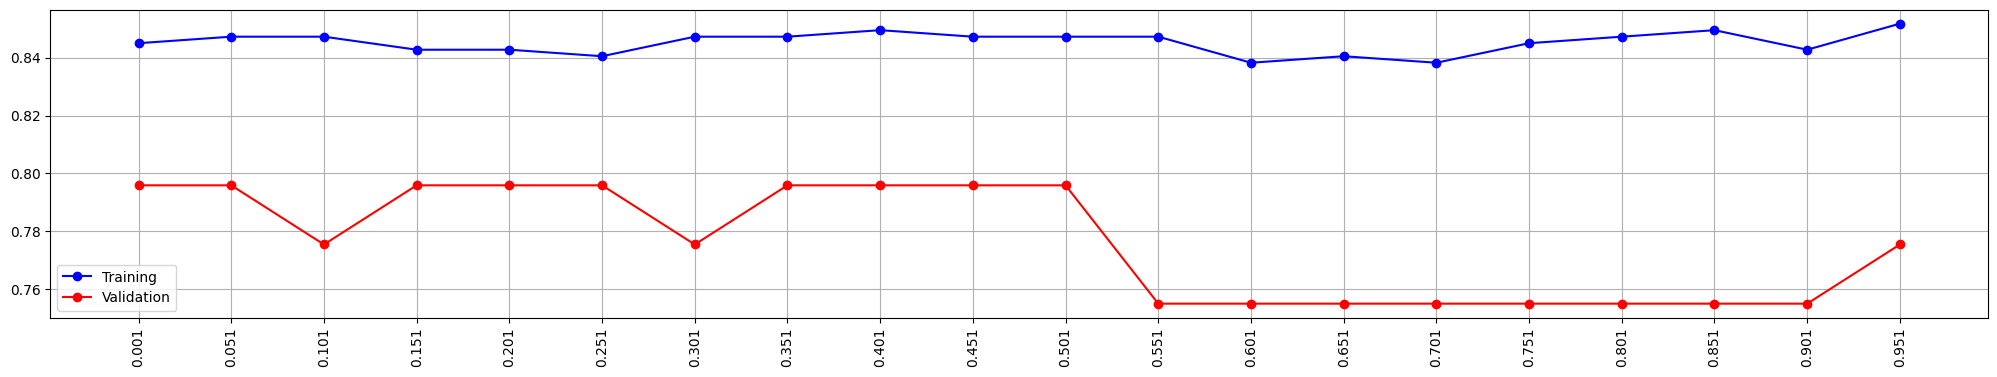

K FOLD #7


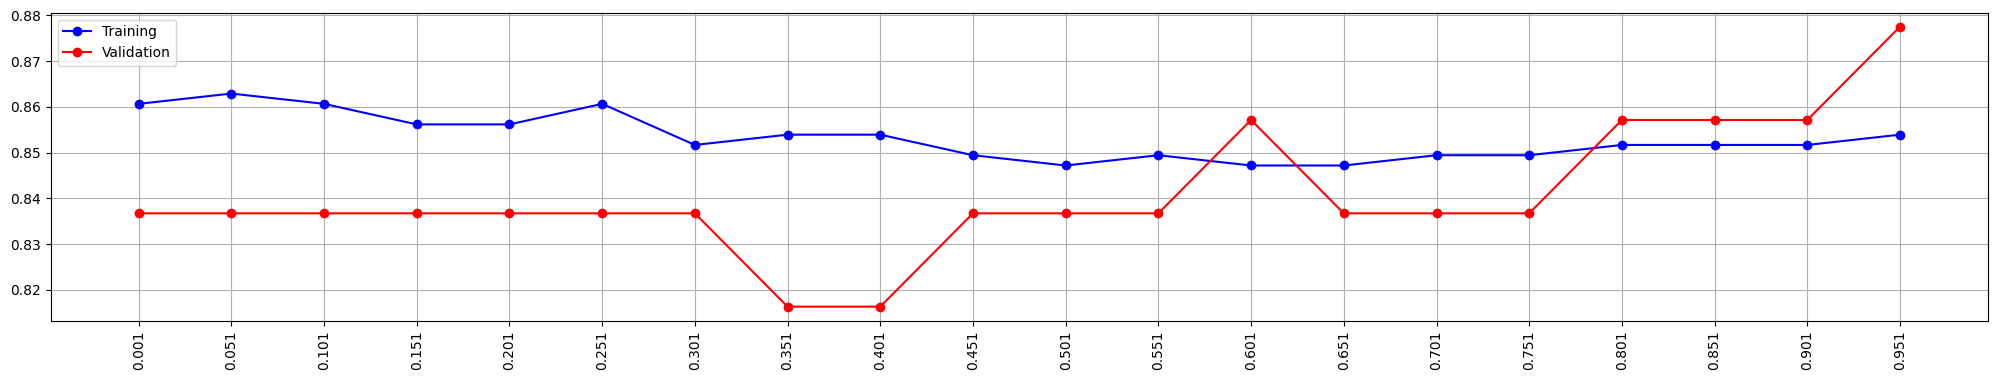

K FOLD #8


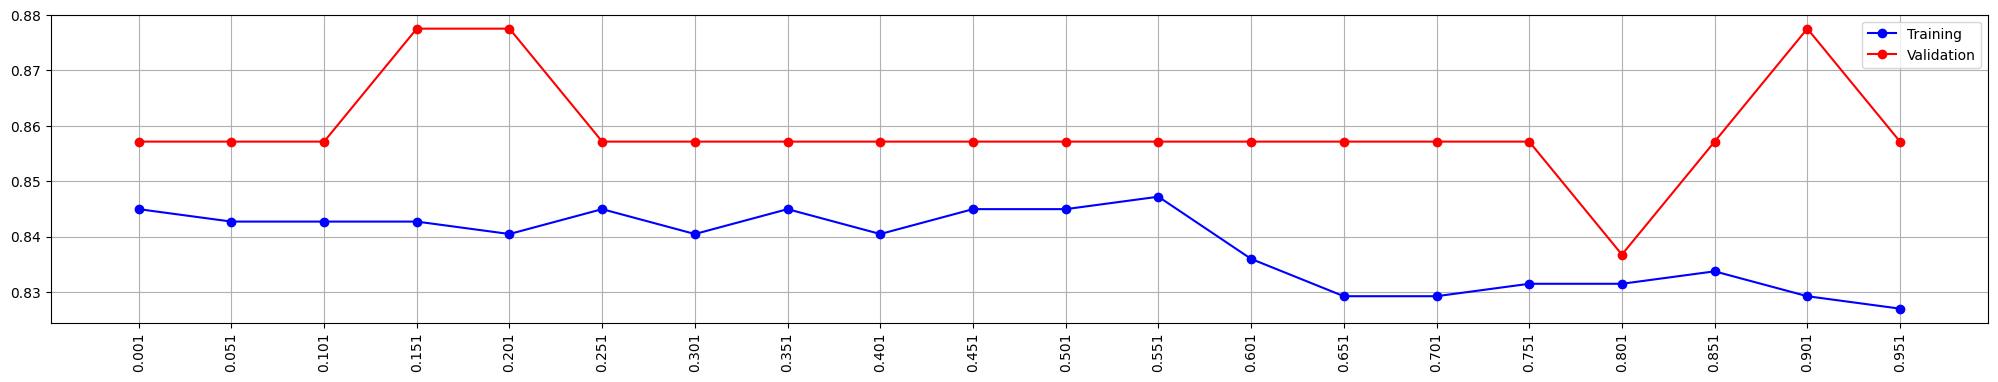

K FOLD #9


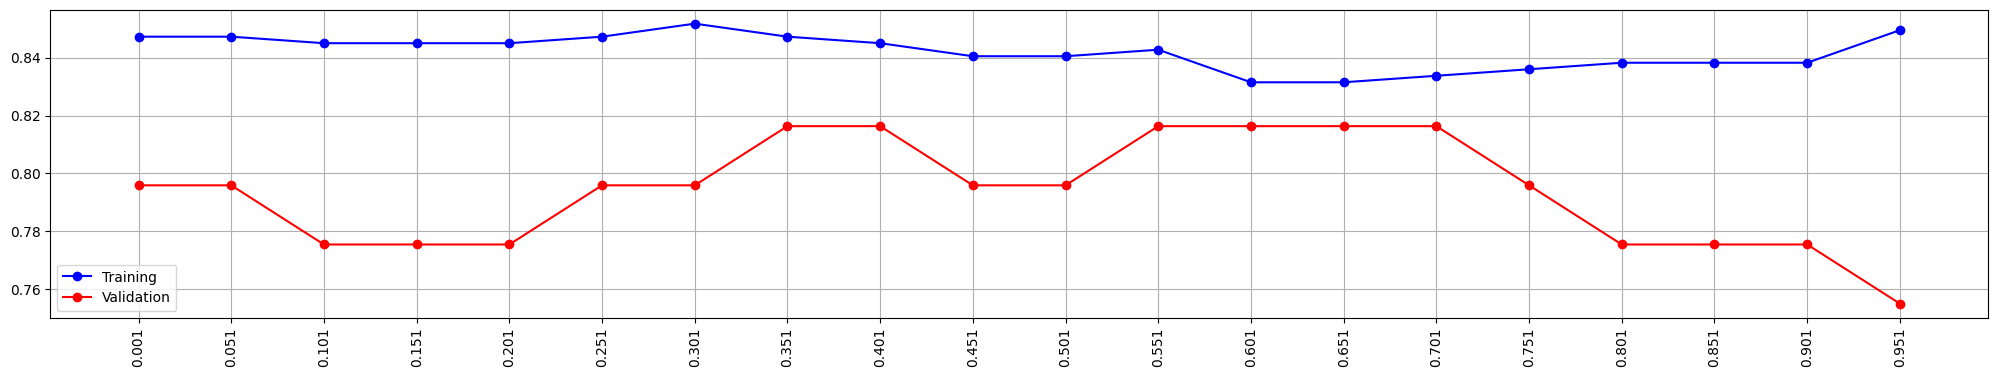

In [14]:
# Perform k-Fold Cross Validation on Train and Test (i.e. Validation) sets
for i, (train_index, validation_index) in enumerate(kf.split(X, y)):

    print(f"K FOLD #{i}")

    X_train, X_validation = X.iloc[train_index], X.iloc[validation_index]
    y_train, y_validation = y.iloc[train_index], y.iloc[validation_index]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_validation = scaler.transform(X_validation)

    accuraciesTrain = []
    accuraciesTest = []
    paramRange = np.arange(0.001, 1.0, 0.05)
    for test in paramRange:
        Cls = SVC(
            random_state = 42, 
            kernel = "linear", # linear, sigmoid, poly, rbf, precomputed
            probability = True,
            tol = test
        )
        Cls.fit(X_train, y_train)

        y_pred_train = Cls.predict(X_train)
        y_pred_validation = Cls.predict(X_validation)
        accuraciesTrain.append(accuracy_score(y_train, y_pred_train))
        accuraciesTest.append(accuracy_score(y_validation, y_pred_validation))
    plt.figure(figsize=(25, 4))
    plt.plot(paramRange, accuraciesTrain, "-o", label = "Training", color = "blue")
    plt.plot(paramRange, accuraciesTest, "-o", label = "Validation", color = "red")
    plt.xticks(paramRange, rotation=90)
    plt.grid(True)
    plt.legend()
    plt.show()

_**DECISION TREE CLASSIFIER**_

K FOLD #0


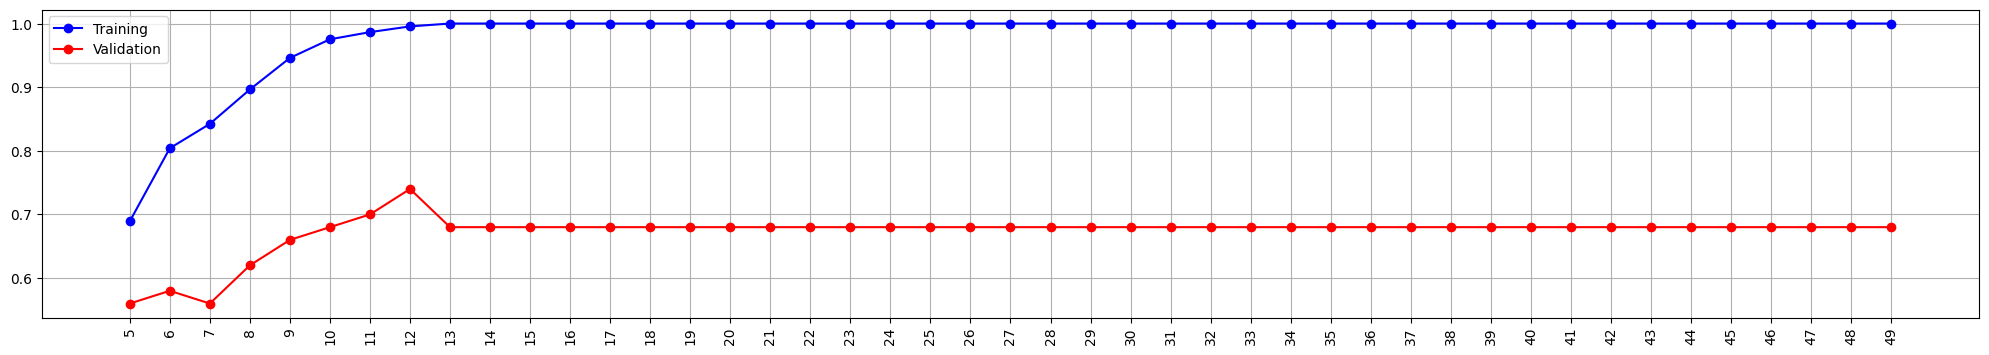

K FOLD #1


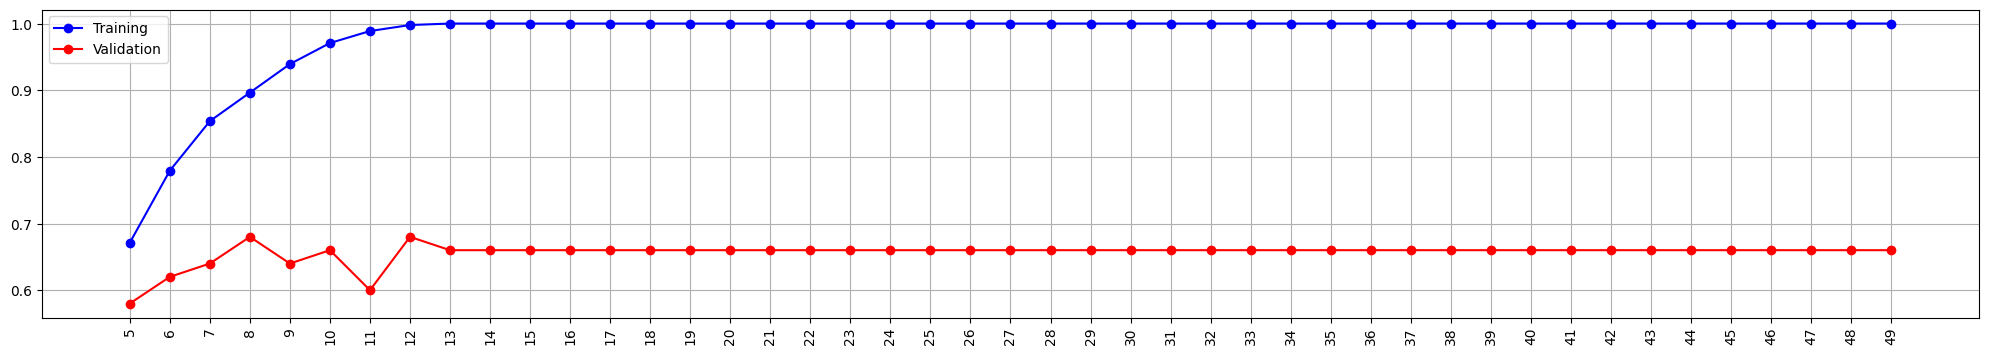

K FOLD #2


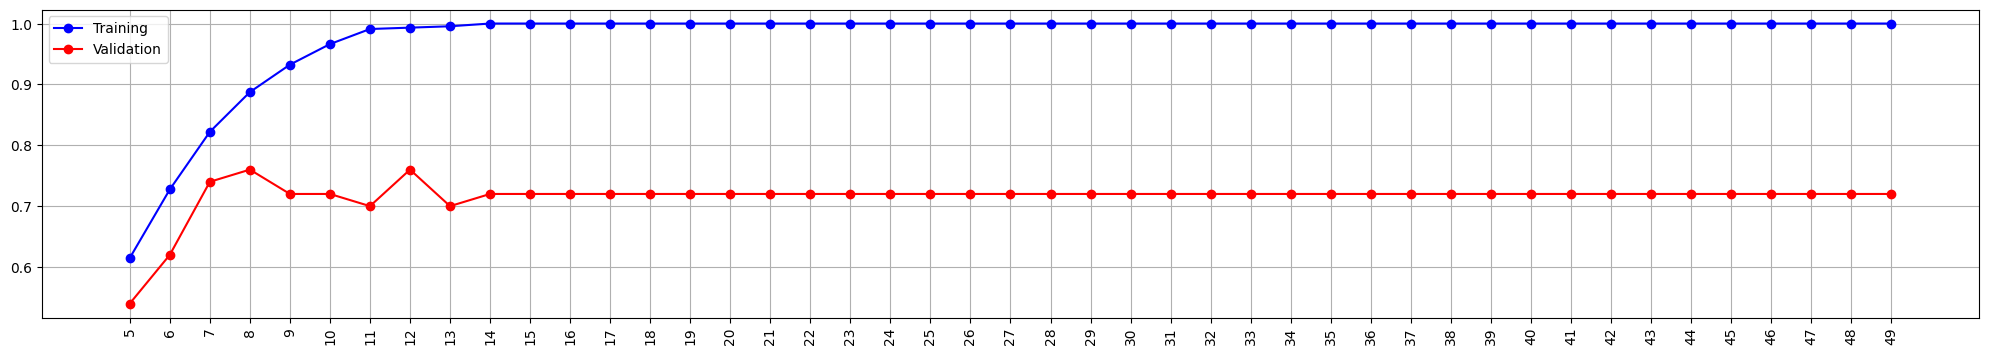

K FOLD #3


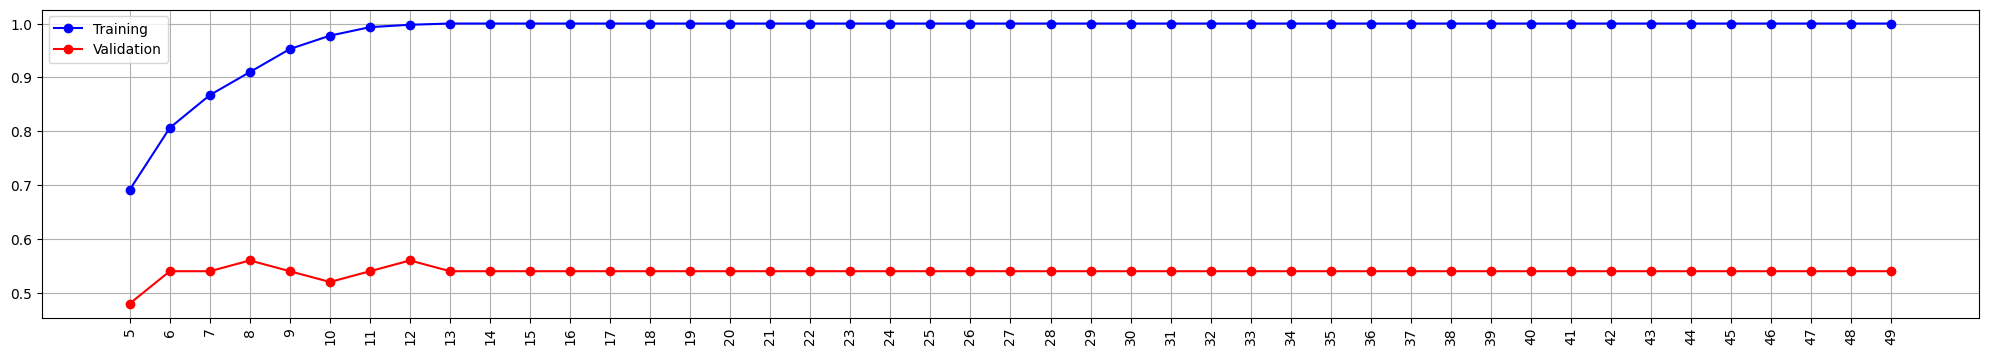

K FOLD #4


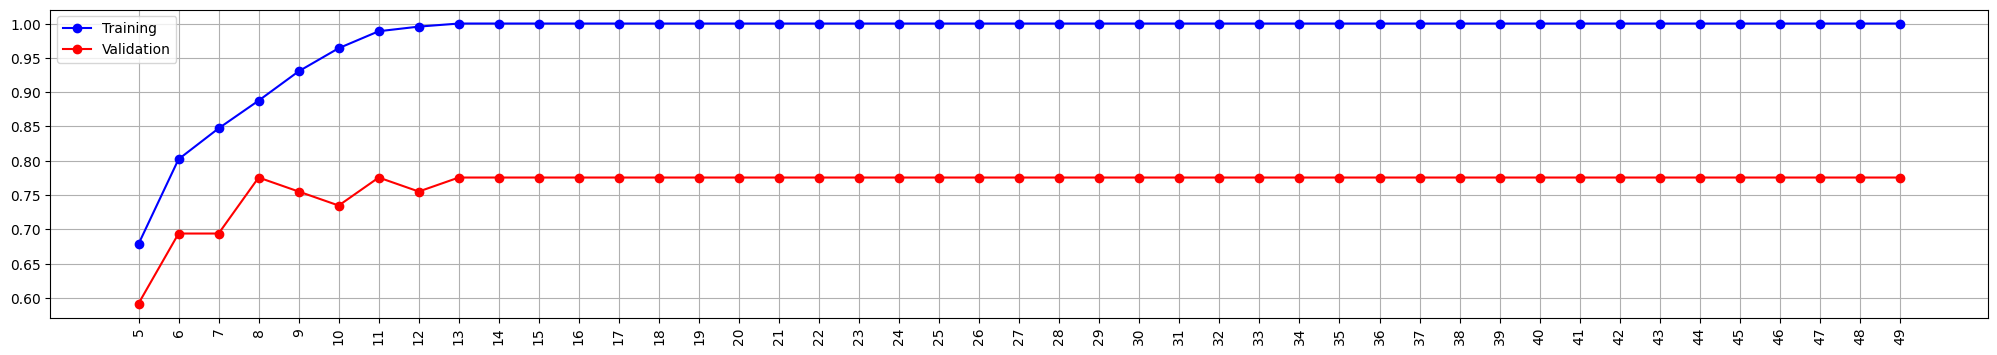

K FOLD #5


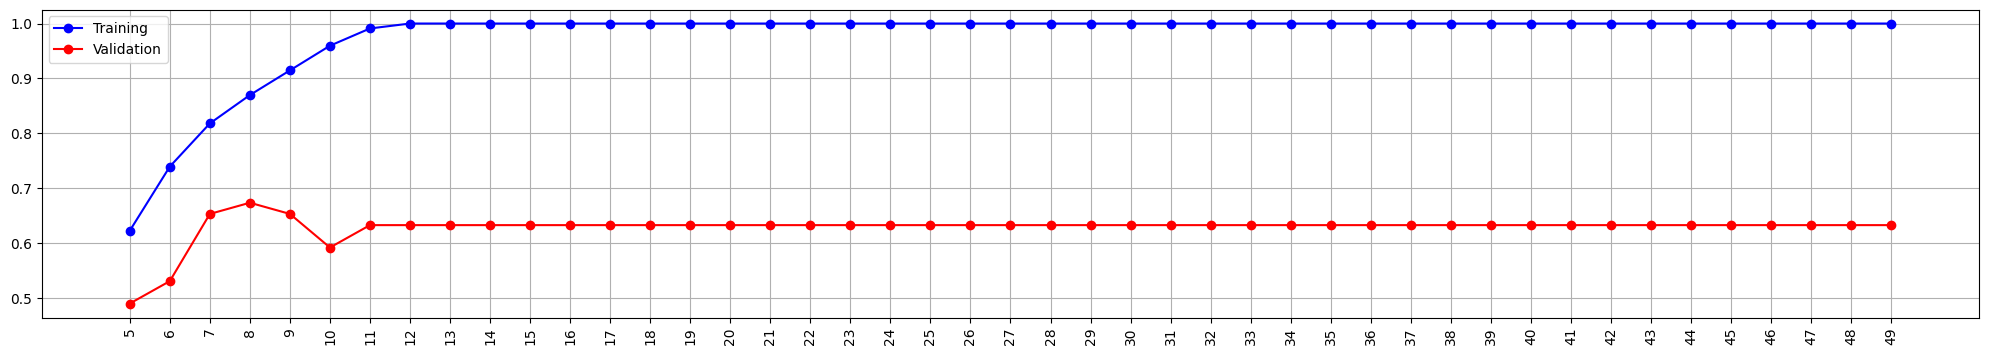

K FOLD #6


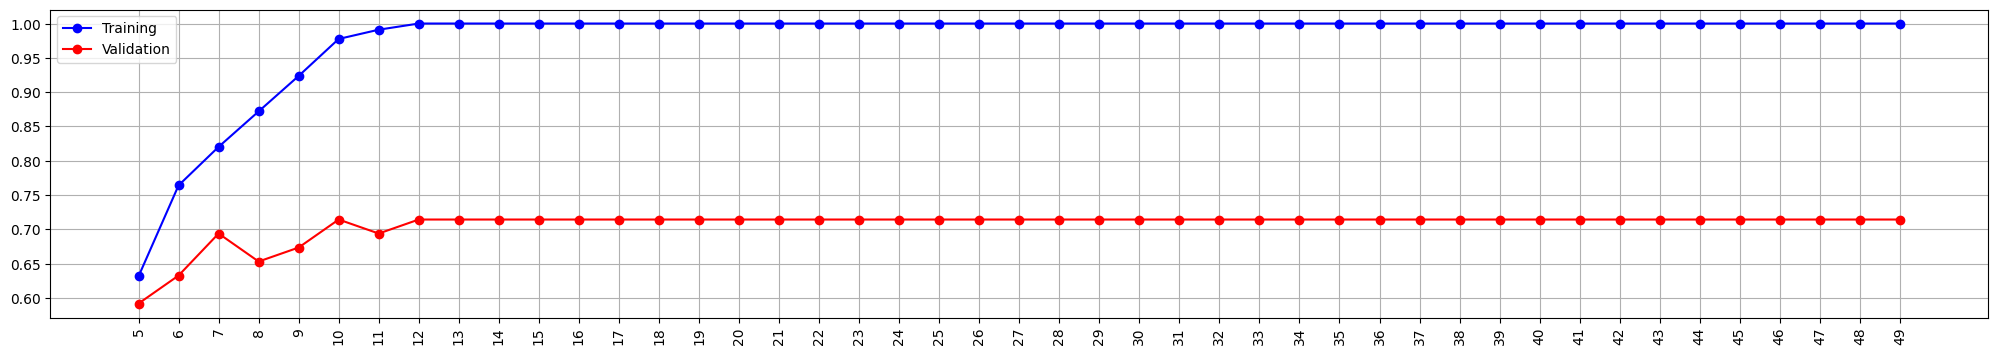

K FOLD #7


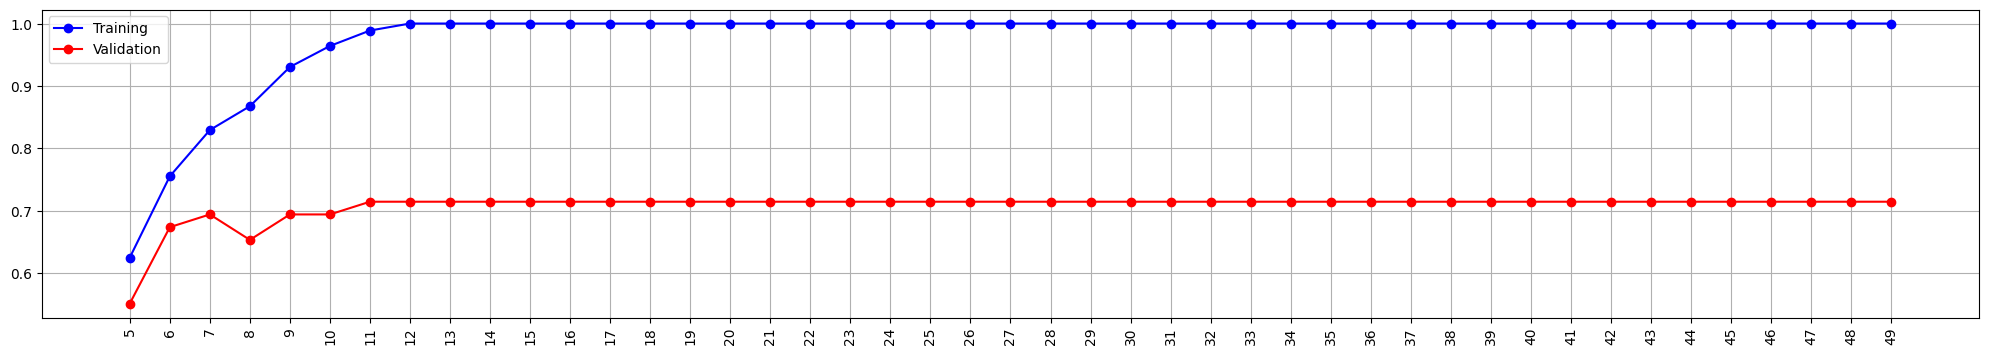

K FOLD #8


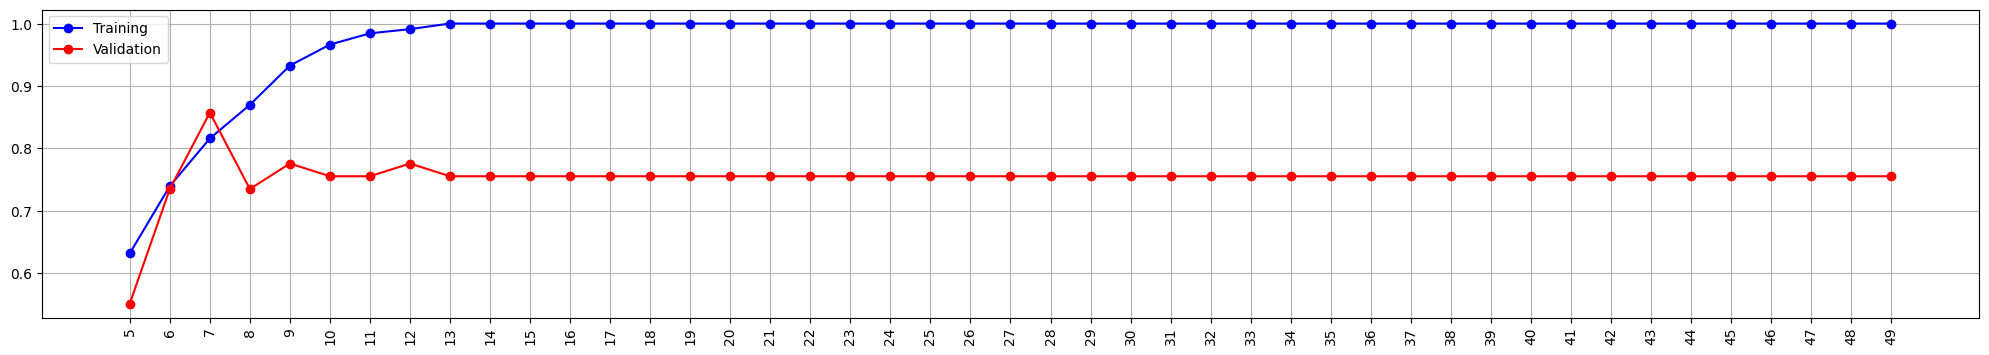

K FOLD #9


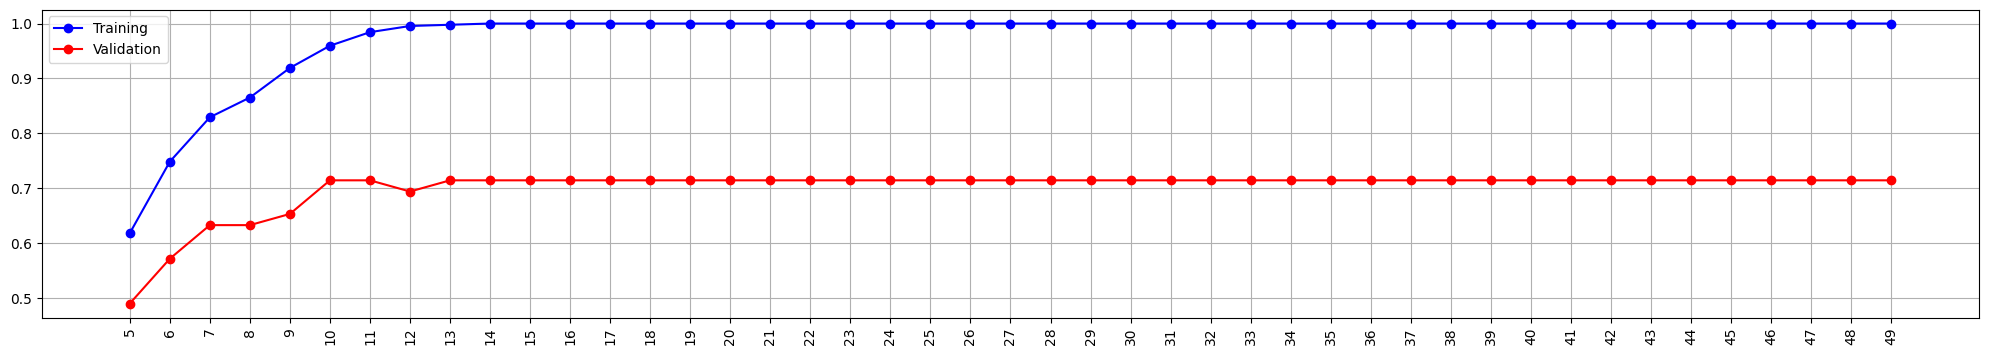

In [15]:
# Perform k-Fold Cross Validation on Train and Test (i.e. Validation) sets
for i, (train_index, validation_index) in enumerate(kf.split(X, y)):

    print(f"K FOLD #{i}")

    X_train, X_validation = X.iloc[train_index], X.iloc[validation_index]
    y_train, y_validation = y.iloc[train_index], y.iloc[validation_index]

    accuraciesTrain = []
    accuraciesTest = []
    paramRange = np.arange(5, 50, 1)
    for test in paramRange:
        Cls = DecisionTreeClassifier(
            random_state = 42,
            criterion = "gini",
            max_depth = test
        )
        Cls.fit(X_train, y_train)

        y_pred_train = Cls.predict(X_train)
        y_pred_validation = Cls.predict(X_validation)
        accuraciesTrain.append(accuracy_score(y_train, y_pred_train))
        accuraciesTest.append(accuracy_score(y_validation, y_pred_validation))
    plt.figure(figsize=(25, 4))
    plt.plot(paramRange, accuraciesTrain, "-o", label = "Training", color = "blue")
    plt.plot(paramRange, accuraciesTest, "-o", label = "Validation", color = "red")
    plt.xticks(paramRange, rotation=90)
    plt.grid(True)
    plt.legend()
    plt.show()

_**RANDOM FOREST CLASSIFIER**_

K FOLD #0


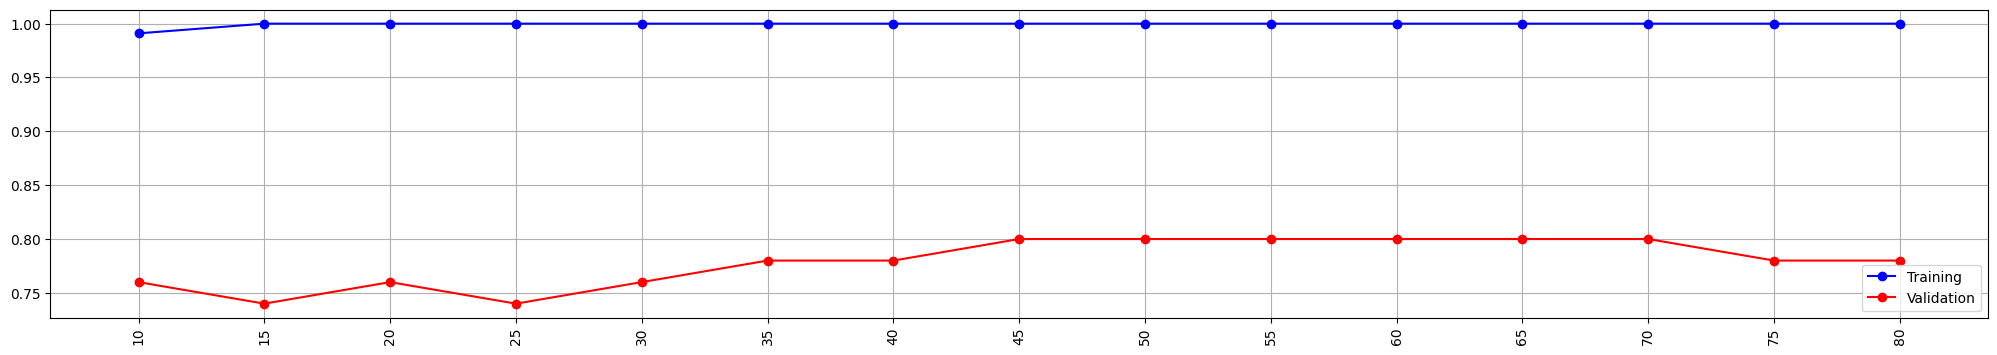

K FOLD #1


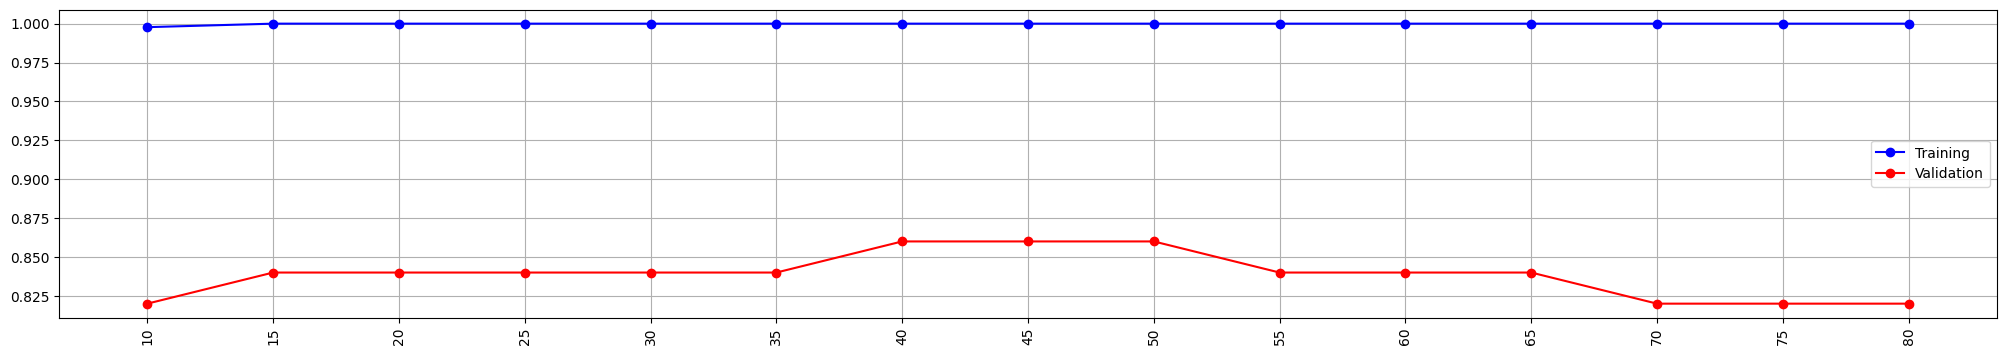

K FOLD #2


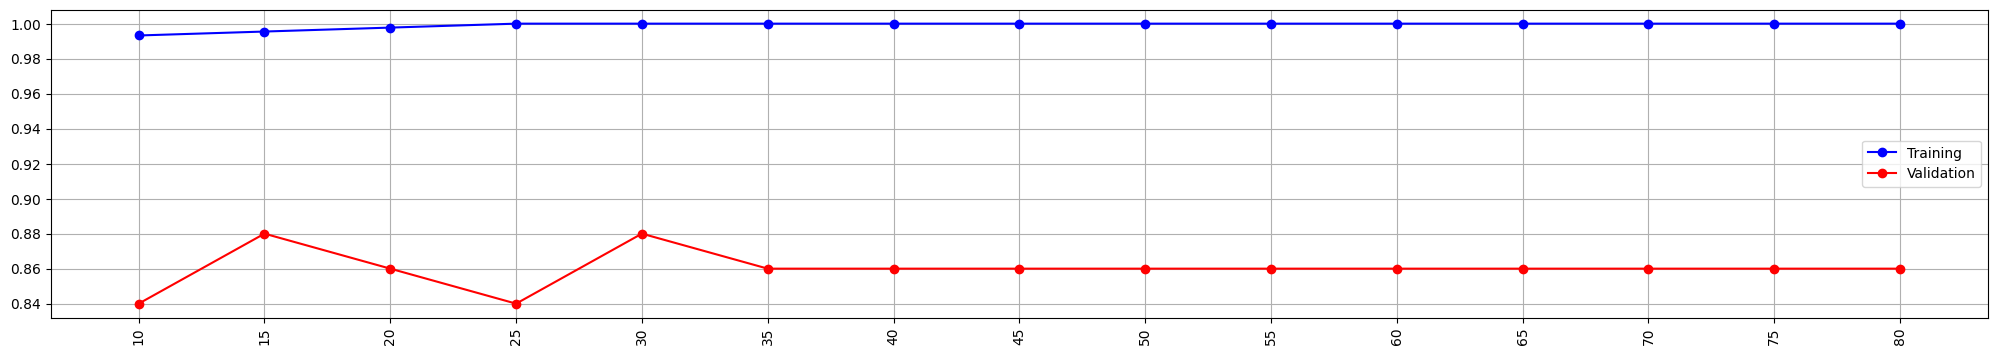

K FOLD #3


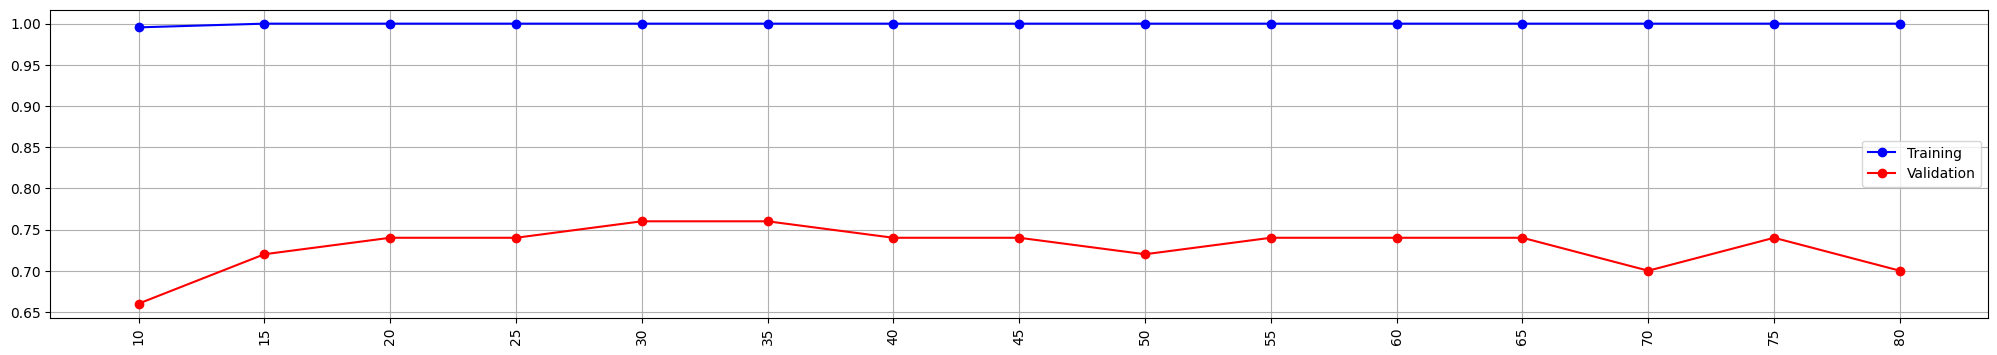

K FOLD #4


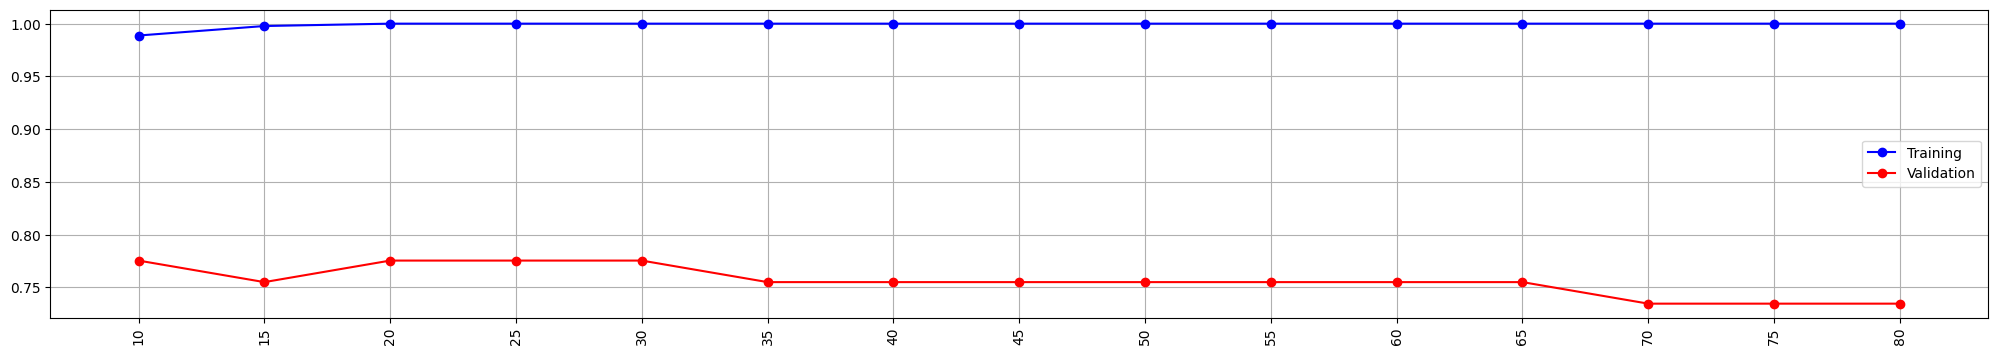

K FOLD #5


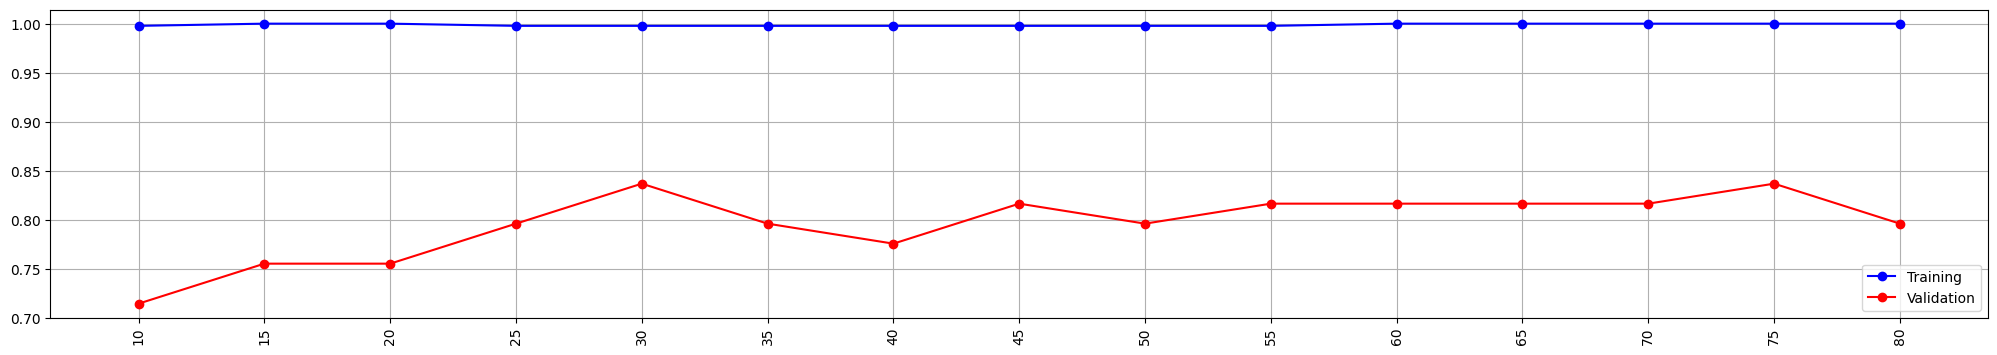

K FOLD #6


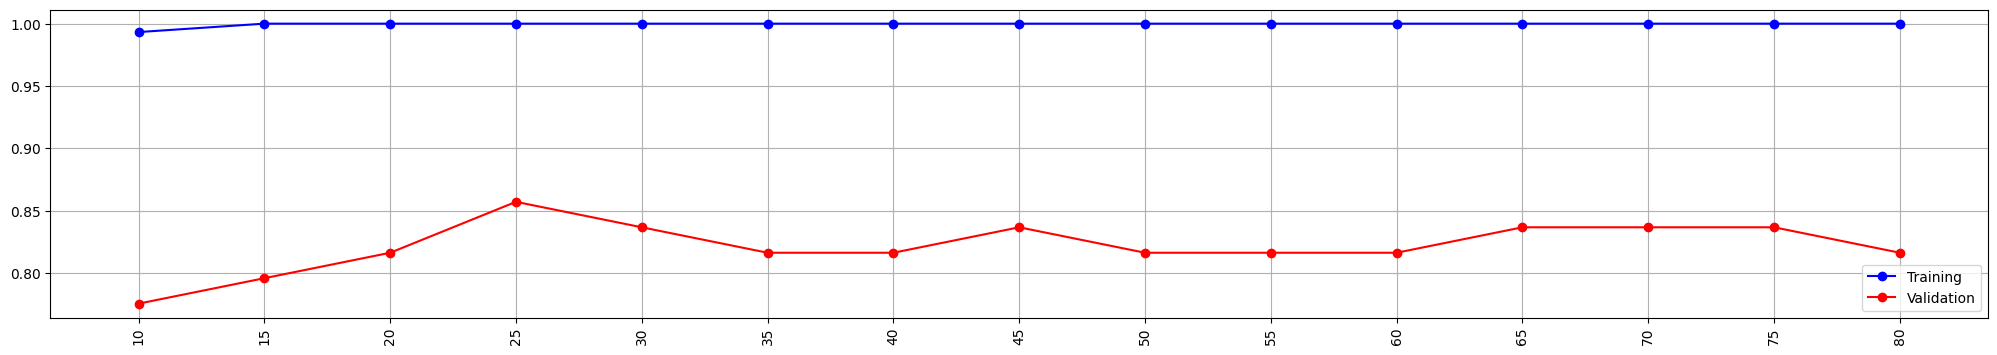

K FOLD #7


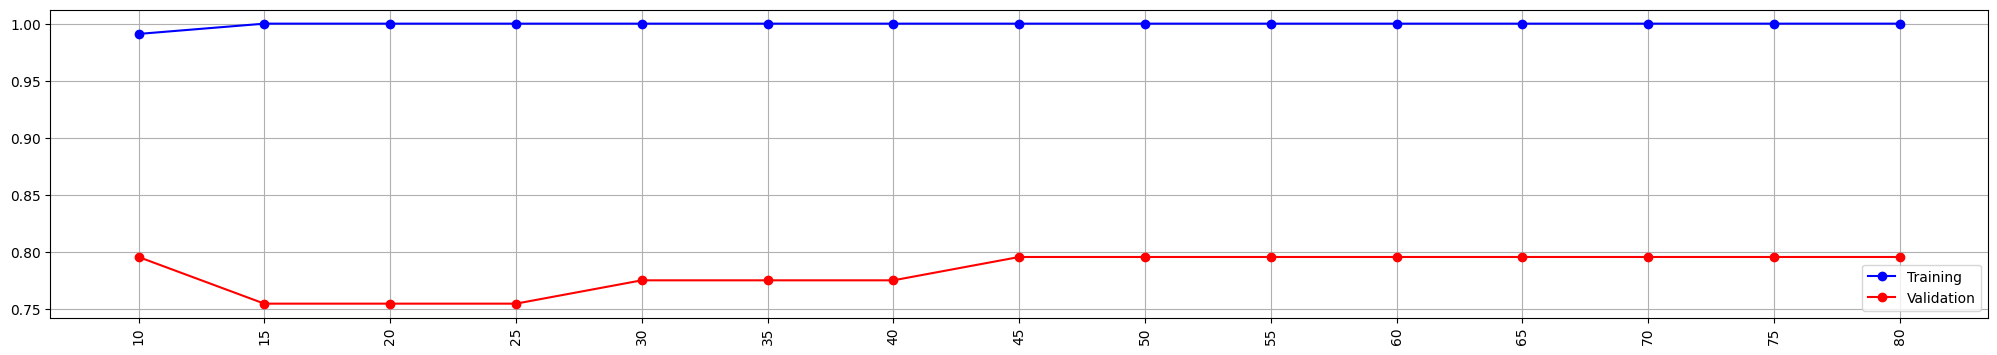

K FOLD #8


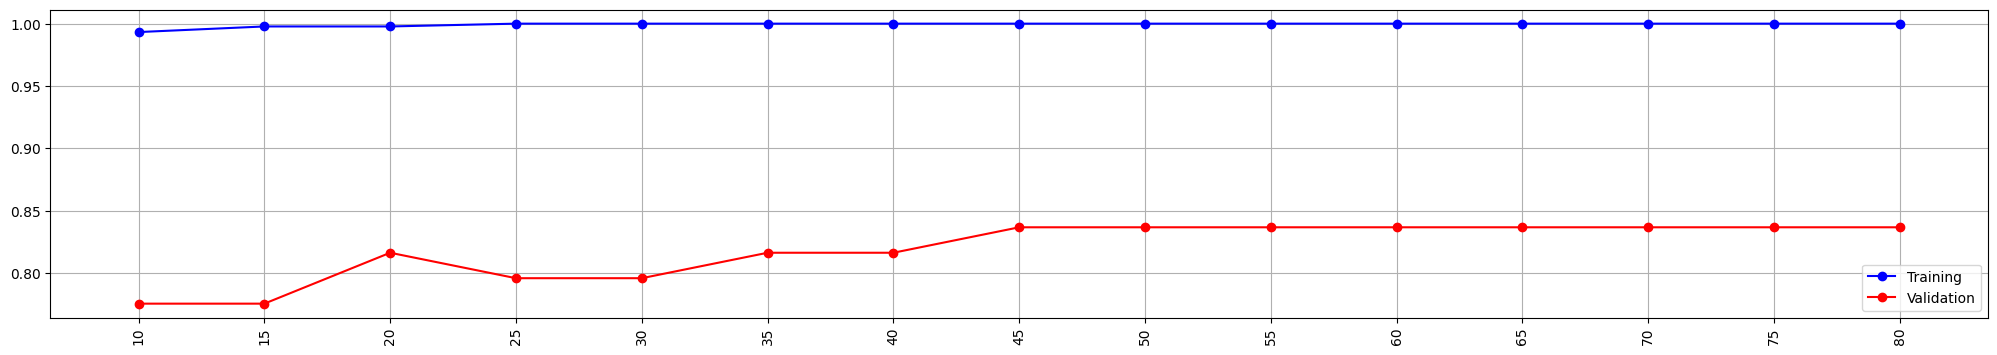

K FOLD #9


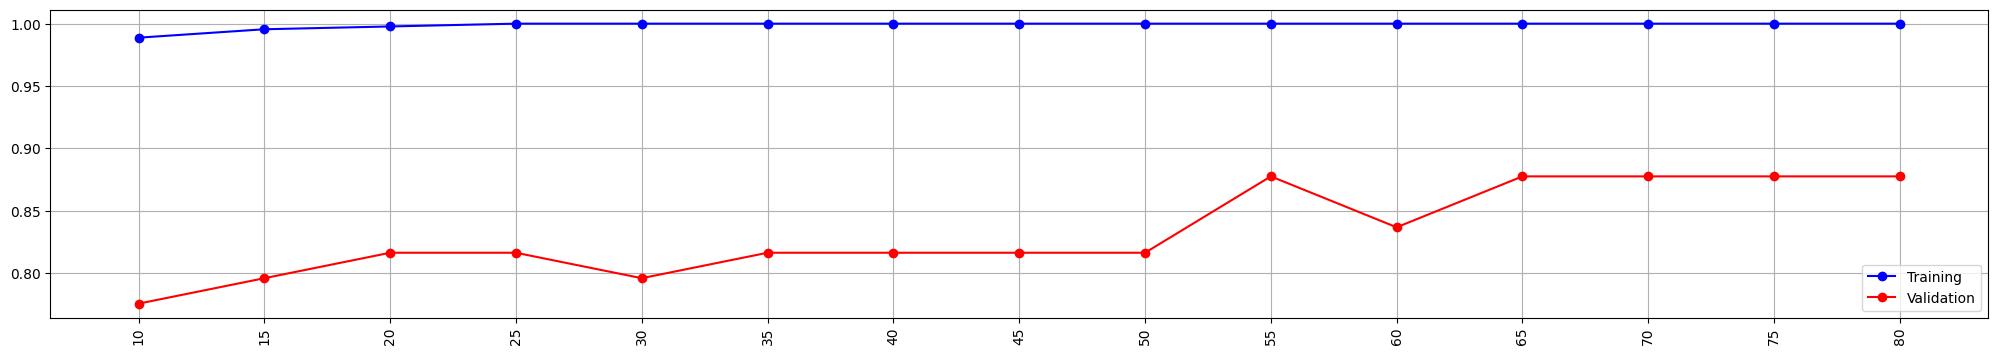

In [65]:
# Perform k-Fold Cross Validation on Train and Test (i.e. Validation) sets
for i, (train_index, validation_index) in enumerate(kf.split(X, y)):

    print(f"K FOLD #{i}")

    X_train, X_validation = X.iloc[train_index], X.iloc[validation_index]
    y_train, y_validation = y.iloc[train_index], y.iloc[validation_index]

    accuraciesTrain = []
    accuraciesTest = []
    paramRange = np.arange(10, 81, 5)
    for test in paramRange:
        Cls = RandomForestClassifier(
            random_state = 42,
            n_estimators = test,
            criterion = "log_loss",
        )
        Cls.fit(X_train, y_train)

        y_pred_train = Cls.predict(X_train)
        y_pred_validation = Cls.predict(X_validation)
        accuraciesTrain.append(accuracy_score(y_train, y_pred_train))
        accuraciesTest.append(accuracy_score(y_validation, y_pred_validation))
    plt.figure(figsize=(25, 4))
    plt.plot(paramRange, accuraciesTrain, "-o", label = "Training", color = "blue")
    plt.plot(paramRange, accuraciesTest, "-o", label = "Validation", color = "red")
    plt.xticks(paramRange, rotation=90)
    plt.grid(True)
    plt.legend()
    plt.show()

**Model Creation with the Hyperparameters Selected**

Now that we have found the (seemingly) best hyperparameters, in this section we train the models with them.

In [66]:
# Perform k-Fold Cross Validation on Train and Test (i.e. Validation) sets
for i, (train_index, validation_index) in enumerate(kf.split(X, y)):

    X_train, X_validation = X.iloc[train_index], X.iloc[validation_index]
    y_train, y_validation = y.iloc[train_index], y.iloc[validation_index]

    # Scaling ---------------------------------------------------------------
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_validation_scaled = scaler.transform(X_validation)

    # Model Validation ---------------------------------------------------------------
    svcCls = SVC(
        random_state = 42, 
        kernel = "linear", # linear, sigmoid, poly, rbf, precomputed
        probability = True,
        tol = 0.201
    )
    dtCls = DecisionTreeClassifier(
        random_state = 42,
        criterion = "gini",
        max_depth = 12
    )
    rfCls = RandomForestClassifier(
        random_state = 42,
        #n_estimators = 65,
        #criterion = "gini",
        n_estimators = 20,
        criterion = "log_loss",
    )
    svcCls.fit(X_train_scaled, y_train)
    dtCls.fit(X_train, y_train)
    rfCls.fit(X_train, y_train)

    y_predSVC = svcCls.predict(X_validation_scaled)
    y_predDT = dtCls.predict(X_validation)
    y_predRF = rfCls.predict(X_validation)

    modelsResults["SVC"]["Accuracy"].append(accuracy_score(y_validation, y_predSVC))
    modelsResults["DT"]["Accuracy"].append(accuracy_score(y_validation, y_predDT))
    modelsResults["RF"]["Accuracy"].append(accuracy_score(y_validation, y_predRF))

    modelsResults["SVC"]["Recall"].append(recall_score(y_validation, y_predSVC, average="macro"))
    modelsResults["DT"]["Recall"].append(recall_score(y_validation, y_predDT, average="macro"))
    modelsResults["RF"]["Recall"].append(recall_score(y_validation, y_predRF, average="macro"))

    modelsResults["SVC"]["Precision"].append(precision_score(y_validation, y_predSVC, average="macro"))
    modelsResults["DT"]["Precision"].append(precision_score(y_validation, y_predDT, average="macro"))
    modelsResults["RF"]["Precision"].append(precision_score(y_validation, y_predRF, average="macro"))

    modelsResults["SVC"]["F1Score"].append(f1_score(y_validation, y_predSVC, average="macro"))
    modelsResults["DT"]["F1Score"].append(f1_score(y_validation, y_predDT, average="macro"))
    modelsResults["RF"]["F1Score"].append(f1_score(y_validation, y_predRF, average="macro"))

    y_probSVC = svcCls.predict_proba(X_validation_scaled)
    y_probDT = dtCls.predict_proba(X_validation)
    y_probRF = rfCls.predict_proba(X_validation)

    modelsResults["SVC"]["AUC"].append(roc_auc_score(y_validation, y_probSVC, multi_class="ovr"))
    modelsResults["DT"]["AUC"].append(roc_auc_score(y_validation, y_probDT, multi_class="ovr"))
    modelsResults["RF"]["AUC"].append(roc_auc_score(y_validation, y_probRF, multi_class="ovr"))

Display the average and individual results of each Fold

In [67]:
for model in modelsResults.keys():

    print("\n\n# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # ")
    print(model)

    print(" ================ ACCURACY")
    print("Per fold:", *(accuracyList := modelsResults[model]["Accuracy"]), sep="   ")
    print(f"Average: {sum(accuracyList)/len(accuracyList)}")

    print(" ================ RECALL")
    print("Per fold:", *(sensitivityList := modelsResults[model]["Recall"]), sep="   ")
    print(f"Average: {sum(sensitivityList)/len(sensitivityList)}")

    print(" ================ PRECISION")
    print("Per fold:", *(precisionList := modelsResults[model]["Precision"]), sep="   ")
    print(f"Average: {sum(precisionList)/len(precisionList)}")

    print(" ================ F1 SCORE")
    print("Per fold:", *(f1ScoreList := modelsResults[model]["F1Score"]), sep="   ")
    print(f"Average: {sum(f1ScoreList)/len(f1ScoreList)}")

    print(" ================ AUC - ROC")
    print("Per fold:", *(aucList := modelsResults[model]["AUC"]), sep="   ")
    print(f"Average: {sum(aucList)/len(aucList)}")



# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
SVC
 ================ ACCURACY
Per fold:   0.82   0.8   0.86   0.76   0.8775510204081632   0.7755102040816326   0.7755102040816326   0.8367346938775511   0.8571428571428571   0.7755102040816326   0.84   0.8   0.86   0.74   0.8775510204081632   0.7551020408163265   0.7959183673469388   0.8367346938775511   0.8775510204081632   0.7755102040816326   0.84   0.8   0.86   0.74   0.8775510204081632   0.7551020408163265   0.7959183673469388   0.8367346938775511   0.8775510204081632   0.7755102040816326
Average: 0.8151564625850339
 ================ RECALL
Per fold:   0.805   0.7999999999999999   0.86   0.76   0.875   0.775   0.78   0.8350000000000002   0.86   0.77   0.825   0.7999999999999999   0.86   0.74   0.875   0.75   0.8   0.8350000000000002   0.8800000000000001   0.77   0.825   0.7999999999999999   0.86   0.74   0.875   0.75   0.8   0.8350000000000002   0.8800000000000001   0.77
Average: 0.8130000000000001
 ==============

<hr />

## Model Testing

In this section, we use the test images from the folder _digitsTest_, which contain the handwritten Student ID of the members of our team. We measure the accuracy of the model and display on the image the digit that our model detected for each one of the digits in the ID.

In [77]:
colnames = ["euler", "Hu1", "Hu2", "Hu3", "Hu4", "Hu5", "Hu6", "Hu7"]
X_test = pd.DataFrame(columns = colnames)
boundariesPerDigit = []

y_test = {
    "Den" : pd.Series([0, 1, 5, 6, 2, 0, 7, 7]),
    "Luis" : pd.Series([0, 1, 3, 7, 8, 2, 4, 8]),
    "Rivers" : pd.Series([0, 1, 3, 7, 8, 9, 6, 5])
}

TEST = "Rivers"           # <--- Change this line if you want to test with someone else's ID

Segment the test image and get the features per digit

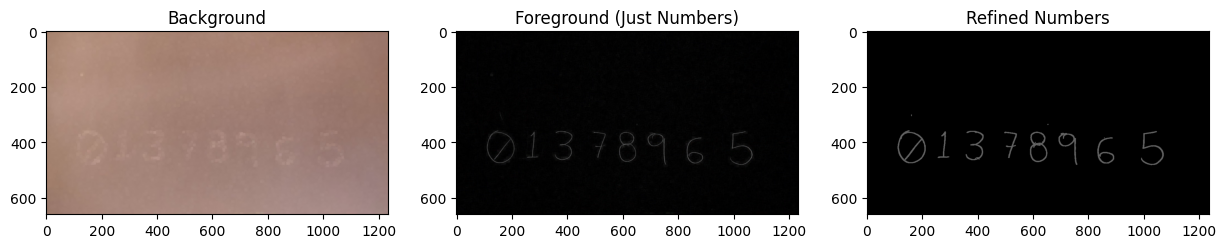

768
745
16
0
22


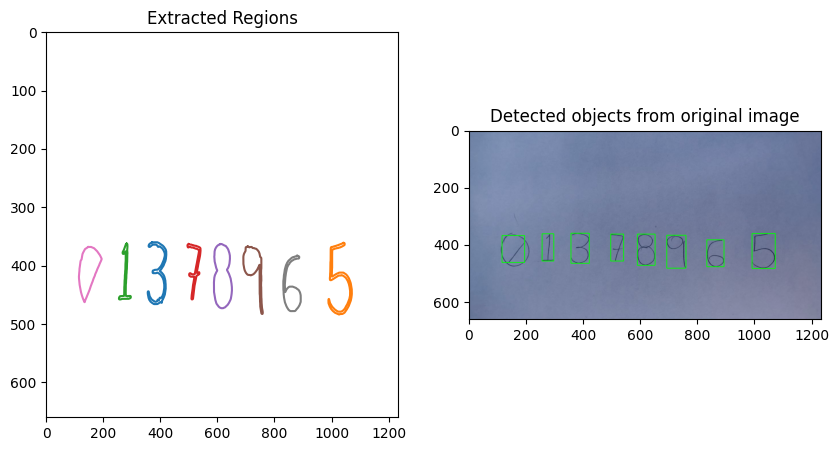

In [78]:
frame = cv.imread(os.path.join("digitsTest", f"{TEST}.jpeg"))
rawImg = frame.copy()

kernel = np.ones((5,5),np.uint8)
bkgnd = cv.dilate(frame,kernel,iterations = 1)
bkgnd = cv.dilate(bkgnd,kernel,iterations = 1)

frame = (bkgnd - frame)
frgnd = frame.copy()

kernel = np.ones((3,3),np.uint8)
frame = cv.dilate(frame,kernel,iterations = 1)

green = frame[:,:,2]
ret,img = cv.threshold(green, 32, 100, 0)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(cv.cvtColor(bkgnd, cv.COLOR_BGR2RGB))
ax[0].set_title("Background")

ax[1].imshow(cv.cvtColor(frgnd, cv.COLOR_BGR2RGB))
ax[1].set_title("Foreground (Just Numbers)")

ax[2].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
ax[2].set_title("Refined Numbers")
plt.show()

# ###################
labeled, regions, EdgeImage = SegmentationRegions(img,frame)

labeled = labeled % 21

img = cv.normalize(labeled, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
im_color = cv.applyColorMap(img, cv.COLORMAP_HSV)
im_color = cv.medianBlur(im_color,3)
RGB_im = cv.cvtColor(im_color, cv.COLOR_BGR2RGB)

# ###################

fig, ax = plt.subplots(1,2, figsize=(10, 5))
for n in range(len(regions)-2):
    idx = n+2
    if regions[idx].Perimetro > PERIMETERS[digit][0]:
        if regions[idx].Perimetro < PERIMETERS[digit][1]:

            pointlist = orderPointSet(regions[idx].edgePoints, EdgeImage)
            smoothpoints = np.array(smoothPointSet(pointlist[0],3))
            euler, hu1, hu2, hu3, hu4, hu5, hu6, hu7, xMin, yMin, xMax, yMax = getInvariantFeatures(pointlist, displayIndividual=False)
            digitFeatures = pd.DataFrame([[euler, hu1, hu2, hu3, hu4, hu5, hu6, hu7]], columns = colnames)
            X_test = pd.concat([X_test, digitFeatures], ignore_index = True)

            boundariesPerDigit.append(((xMin, yMin), (xMax, yMax)))

            ax[0].plot(smoothpoints[:,0],smoothpoints[:,1])

ax[0].set_ylim(frame.shape[0], 0)
ax[0].set_xlim(0, frame.shape[1])
ax[0].set_title("Extracted Regions")

boundedImg = rawImg.copy()
for startPoint, endPoint in boundariesPerDigit:
    cv.rectangle(boundedImg, startPoint, endPoint, (0,255,0), 2)
ax[1].imshow(boundedImg)
ax[1].set_title("Detected objects from original image")

plt.show()

Sort the detected elements based on their appearance in the page (from left to right)

In [79]:
# Pair the DataFrame rows (only values) and boundary tuples
pairedData = zip(X_test.itertuples(index=False, name=None), boundariesPerDigit)

# Sort the pairs by the xMin value of each tuple
sortedPairs = sorted(pairedData, key=lambda pair: pair[1][0][0])

X_test = pd.DataFrame([row for row, _ in sortedPairs], columns=X_test.columns)
boundariesPerDigit = [bound for _, bound in sortedPairs]


In [80]:
X_test

euler       Hu1        Hu2        Hu3       Hu4        Hu5       Hu6  \
0   -348  6.773842   6.970468  26.018195  1.079363  -4.896685 -2.849619   
1   -326  3.885601  12.070505   7.139027  2.090368   7.960518  7.085440   
2   -636  3.715669   4.874793   4.204810  1.057521  -2.179013 -2.277989   
3   -400  3.086699   5.135050   6.828121  0.729274  -0.761329 -0.337087   
4   -388  6.864169   8.883627   1.172738  0.202881  -0.086722  0.604686   
5   -412  4.767428   9.909504  27.881572  2.209706 -16.756491 -6.530058   
6   -432  4.062084   2.969372  11.598192  3.069221  -9.049546 -4.606719   
7   -718  3.924083   3.646848   3.141065  0.020356  -0.002614  0.028781   

         Hu7  
0  -2.956335  
1   1.356146  
2   0.474182  
3  -1.438305  
4   0.047671  
5   4.477708  
6  15.919722  
7  -0.004434

In [81]:
boundariesPerDigit

[((np.int64(115), np.int64(368)), (np.int64(194), np.int64(462))),
 ((np.int64(255), np.int64(362)), (np.int64(296), np.int64(457))),
 ((np.int64(356), np.int64(360)), (np.int64(420), np.int64(465))),
 ((np.int64(495), np.int64(363)), (np.int64(540), np.int64(457))),
 ((np.int64(588), np.int64(363)), (np.int64(650), np.int64(472))),
 ((np.int64(691), np.int64(367)), (np.int64(758), np.int64(482))),
 ((np.int64(831), np.int64(383)), (np.int64(891), np.int64(477))),
 ((np.int64(989), np.int64(361)), (np.int64(1070), np.int64(483)))]

Perform the actual prediction on the test set

_**SUPPORT VECTOR CLASSIFIER**_

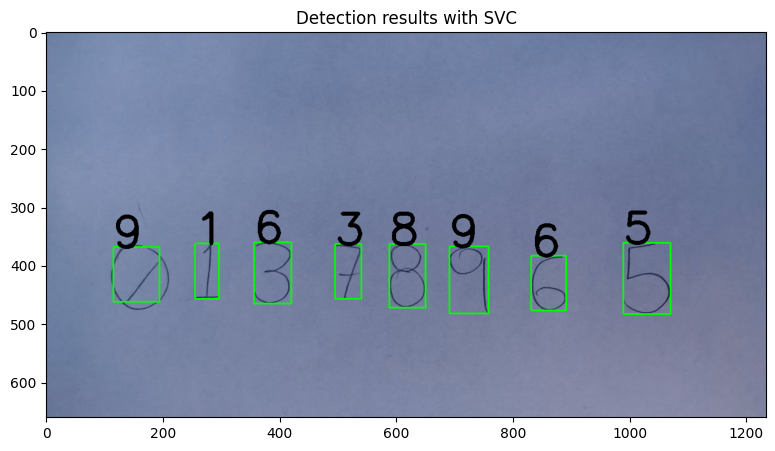

ACCURACY: 0.625


In [82]:
X_test = scaler.transform(X_test)

# Performance of the model in the test set
y_pred = svcCls.predict(X_test)

fig = plt.figure(figsize=(10, 5))
boundedImg = rawImg.copy()
for i, (startPoint, endPoint) in enumerate(boundariesPerDigit):
    cv.rectangle(boundedImg, startPoint, endPoint, (0,255,0), 2)
    cv.putText(boundedImg, str(y_pred[i]), startPoint, cv.FONT_HERSHEY_SIMPLEX, 2.5, (0,0,0), 5)

plt.imshow(boundedImg)
plt.title("Detection results with SVC")
plt.show()

print(f"ACCURACY: {accuracy_score(y_test[TEST], y_pred)}")

_**DECISION TREE CLASSIFIER**_


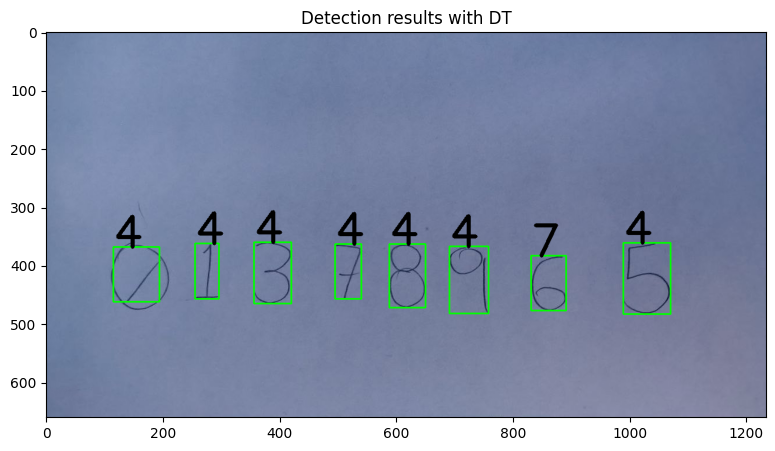

ACCURACY: 0.0


In [83]:
# Performance of the model in the test set
y_pred = dtCls.predict(X_test)

fig = plt.figure(figsize=(10, 5))
boundedImg = rawImg.copy()
for i, (startPoint, endPoint) in enumerate(boundariesPerDigit):
    cv.rectangle(boundedImg, startPoint, endPoint, (0,255,0), 2)
    cv.putText(boundedImg, str(y_pred[i]), startPoint, cv.FONT_HERSHEY_SIMPLEX, 2.5, (0,0,0), 5)

plt.imshow(boundedImg)
plt.title("Detection results with DT")
plt.show()

print(f"ACCURACY: {accuracy_score(y_test[TEST], y_pred)}")

_**RANDOM FOREST CLASSIFIER**_

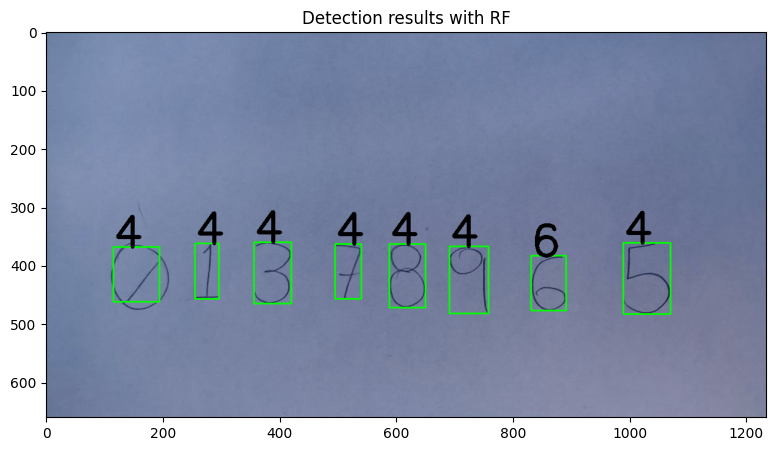

ACCURACY: 0.125


In [84]:
# Performance of the model in the test set
y_pred = rfCls.predict(X_test)

fig = plt.figure(figsize=(10, 5))
boundedImg = rawImg.copy()
for i, (startPoint, endPoint) in enumerate(boundariesPerDigit):
    cv.rectangle(boundedImg, startPoint, endPoint, (0,255,0), 2)
    cv.putText(boundedImg, str(y_pred[i]), startPoint, cv.FONT_HERSHEY_SIMPLEX, 2.5, (0,0,0), 5)

plt.imshow(boundedImg)
plt.title("Detection results with RF")
plt.show()

print(f"ACCURACY: {accuracy_score(y_test[TEST], y_pred)}")

## CONCLUSIONS

All methods seemed to have good performance on training and validation sets. However, SVC is the only one that remained somewhat consistent when faced with the testing set. On the other hand, RFs seemed to have really good performance over the validation set, but when faced with testing samples, it performed poorly; in fact, it was the lowest of the three methods used.